# Data visualization for quench data

In [1]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nptdms import TdmsFile #Process ramping file


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def read_data_from_single_file(filepath):
    """Read in quench data from a given file, return a pandas dafa frame"""
    
    data_dict= {}
    
    with open(filepath) as f:
        content = f.readlines()
    #Remove`\n` at the end of each line
    content = [x.strip() for x in content]
    
    column_names = content[0].split(" ")
    data = [content[i].split("   ") for i in range(1, len(content))] 
    
    for i in range(len(column_names)):
        data_dict[column_names[i]] = [float(x[i]) for x in data]
        
    data_frame = pd.DataFrame(data_dict)
    
    return data_frame

def read_quench_data(area_path, quench_name):
    """
    Read the quench data from the provided file path, note that there are five quenches so we need to concatenate them together.
    Just need to provide the quench's name, for e.g: "./data/mqxfs1b.Quench.161011115654"
    """
    
    data_list = []
    
    
    num_file = 0 #Number of separate data files for this quench, assuming at least one
    
    for filename in os.listdir(area_path):
        if filename.startswith(quench_name) and not filename.endswith(".tar.gz"):
            #print("Reading file ... " + filename)
            if num_file == 0:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename)) #read first file separately
                except:
                    pass
            else:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename).drop(columns = ["time"])) #Time is already saved in the first file
                except:
                    pass
            num_file += 1
                                 
    #print("Total number of data files for {}: ".format(quench_name), num_file)
    
    if len(data_list) != 0:
        data = pd.concat(data_list, axis = 1) #Concatenate all data files together
        return data
    else:
        print("Returning None due to file errors in " + quench_name)
        return None

def read_all_quench_in_area(area_path):
    """
    Read all quench's files in the area and return a dictionary of different quench's data. name is the magnet's name
    """
    data = {}
    
    index = 1 #For indexing different quench

    for filename in os.listdir(area_path):
        if filename.endswith(".tar.gz"): 
            #print("Reading data from ... " + filename[0:-7])
            data[filename[0:-7]] = read_quench_data(area_path, filename[0:-7])
            index += 1
            
    #print("Completed. There are {} quenches in total.".format(str(index - 1)))
    
    return data

def plot_variables_with_time(data, variables = None, time_range = None):
    """
    Take a data frame, and plot all other variables with time.
    Optional argument: time_range to specify the range to plot, default is to plot all time. Example argument
    is (start_time, end_time)
    """
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    if variables:
        for variable in variables:
            plt.figure(figsize=(20,2))
            plt.plot(data["time"], data[variable])
            plt.xlabel("Time (s)")
            plt.title("Variable {}".format(variable))
            plt.show()
        
    else:      
        #If variables not specified then just plot all 
        for variable in data.columns[1:]:
            plt.figure(figsize=(25,2))
            plt.plot(data["time"], data[variable])
            plt.xlabel("Time (s)")
            plt.title("Variable {}".format(variable))
            plt.show()

def plot_statistics(data, variables = None, time_range = None, window = 100):
    """Take a data frame and plot the variable with its moving average and real data in the specified range, if
    variables are not specified then just plot all variables by default"""
    #Pickout the data
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    def plot_signal_and_statistics(variable):
        # Plotted by calculating Simple Moving Average (SMA)
        plt.figure(figsize=(20,2))
        
        plt.plot(data["time"], data[variable], label = "Signal with noise")
        
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).mean(),label = "Moving average")
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).min(),label = "Moving min")
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).max(),label = "Moving max")
        plt.legend(loc = "best")
        plt.xlabel("Time (s)")
        plt.title("Variable {}".format(variable))
        plt.show()
        

        #Variance
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).std(),
                 label = "Standard Deviation",
                 color = 'red')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Standard Deviation".format(variable))
        plt.show()
        
        #Kurtosis
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).kurt(),
                 label = "Kurtosis",
                 color = 'green')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Kurtosis".format(variable))
        plt.show()
        
        #Skew
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).skew(),
                 label = "Skew",
                 color = 'purple')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Skew".format(variable))
        plt.show()
        
        """
        #Quantile
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.25), label = "Quantile 25",
                 color = 'red')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.75), label = "Quantile 75",
                 color = 'orange')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.50), label = "Quantile 50",
                 color = 'green')
        plt.legend(loc = "best")
        plt.title("Variable {}'s Quantile".format(variable))
        plt.show()
        """
        
    #Plot
    if variables:
        for variable in variables:
            print(variable)
            plot_signal_and_statistics(variable)         
    else:
        for variable in data.columns[1:]:
            print(variable)
            plot_signal_and_statistics(variable)
    
    %reset -f in

def plot_variable(data_dict, variable, time_range = None, window = 100):
    for quench_name in data_dict.keys():
        print("Quench's index: " + quench_name)
        if data_dict[quench_name] is not None:
            if variable[0] in list(data_dict[quench_name].columns):
                plot_statistics(data_dict[quench_name], variables = variable, time_range=time_range, window=window)


########### PROCESS RAMPING DATA ###############
def read_tdms_file(filepath):
    """Read the tdms file from a given path, return a pandas data frame of the tdms file"""
    tdms_file = TdmsFile.read(data_path)
    
    data_frame = tdms_file.as_dataframe()
    
    del tdms_file
    
    #Just the last 3 symbols in columns name matter ('/'_unnamedTask<3>'/'PXI2Slot14/ai0') -> ai0
    #Rename the columns
    rename_map = []
    
    for column in data_frame.columns:
        rename_map.append(column[-4:-1])
    
    data_frame.columns = rename_map
    
    #Add time axis relative to the time when quench happens
    time_range = np.asarray(range(data_frame.shape[0]))
    

    #Center around the max value (quench happens at 0 time)
    max_index = data_frame['ai7'].idxmax()
    time_range -= max_index
    time_range = time_range.astype('float32')
    
    #Multiply by datarate
    time_range = np.multiply(time_range, 1e-5, out=time_range, casting="unsafe")
    
    data_frame['time'] = time_range
    
    return data_frame

def break_tdms_to_files(file_path):
    """Read the tdms file and break it into several files according to channels in a new directory"""
    tdms_file = TdmsFile.read(file_path)
    
    data_frame = tdms_file.as_dataframe()
    
    del tdms_file
    
    os.mkdir("./data/" + file_path[-10:-5])
    
    for channel in data_frame.columns[:8]:
        np.save("./data/{}/{}".format(file_path[-10:-5], channel[-4:-1]), data_frame.loc[:, channel].to_numpy())

def calculate_time(dir_path):
    """Take a tdms file directory path (after the file is broken up), and calculate and output a time file."""
    
    ai7 = np.load(dir_path + "ai7.npy")
    
    #Add time axis relative to the time when quench happens
    time_range = np.asarray(range(ai7.shape[0]))
    
    #Center around the max value (quench happens at 0 time)
    max_index = np.argmax(ai7)
    time_range -= max_index
    time_range = time_range.astype('float32')
    
    #Multiply by datarate
    time_range = np.multiply(time_range, 1e-5, out=time_range, casting="unsafe")
    
    np.save(dir_path + "time", time_range)

def load_channel_and_time(dir_path, channel):
    data_frame = pd.DataFrame(data = {channel: np.load(dir_path + channel + ".npy"),
                                     "time": np.load(dir_path + "time.npy")})
    return data_frame

def plot_channel(data, channel, time_range = None):
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data[channel])
    plt.xlabel("Time (s)")
    plt.ylabel("Volt")
    #plt.ylim([-1.5,1.5])
    #plt.xlim([-650,100])
    plt.title("Variable {}".format(channel))
    plt.show()
    
    %reset -f in

    
def calculate_max_current_time(dir_path, ramp_num):
    
    current = load_channel_and_time(dir_path, "ai7")
    
    %reset -f in
    
    if ramp_num == 19:
        return current[current['ai7'] >= 4.672324]["time"].iloc[0]
    
    elif ramp_num == 20:
        return current[current['ai7'] >= 5.615348]["time"].iloc[0]
    
    elif ramp_num == 21:
        return current[current['ai7'] >= 5.822541]["time"].iloc[0]
    
    elif ramp_num == 22:
        return current[current['ai7'] >= 5.804141]["time"].iloc[0]
    
    elif ramp_num == 23:
        return current[current['ai7'] >= 5.843059]["time"].iloc[0]
    
    elif ramp_num == 24:
        return current[current['ai7'] >= 5.970426]["time"].iloc[0]
    
    elif ramp_num == 25:
        return current[current['ai7'] >= 6.056884]["time"].iloc[0]
    
    elif ramp_num == 26:
        return current[current['ai7'] >= 6.19826]["time"].iloc[0]
    
    elif ramp_num == 27:
        return current[current['ai7'] >= 6.342255]["time"].iloc[0]
    
    elif ramp_num == 28:
        return current[current['ai7'] >= 5.870774]["time"].iloc[0]
    
    elif ramp_num == 29:
        return current[current['ai7'] >= 5.961583]["time"].iloc[0]
    
    

def plot_channel_and_max_current(data, channel, dir_path, time_range = None):
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data[channel])
    plt.xlabel("Time (s)")
    plt.ylabel("Volt")
    plt.ylim([-1.5,1.5])
    
    #Max current from previous ramps
    plt.vlines(calculate_max_current_time(dir_path, ramp_num = 19), -1.5, 1.5, color = "blue", linestyles = "dashed", label = "Ramp19 Max I reached")
    plt.vlines(calculate_max_current_time(dir_path, ramp_num = 20), -1.5, 1.5, color = "red", linestyles = "dashed", label = "Ramp20 Max I reached") 
    plt.vlines(calculate_max_current_time(dir_path, ramp_num = 21), -1.5, 1.5, color = "g", linestyles = "dashed", label = "Ramp21 Max I reached") 
    plt.vlines(calculate_max_current_time(dir_path, ramp_num = 22), -1.5, 1.5, color = "orchid", linestyles = "dashed", label = "Ramp22 Max I reached")
    plt.vlines(calculate_max_current_time(dir_path, ramp_num = 23), -1.5, 1.5, color = "darkviolet", linestyles = "dashed", label = "Ramp23 Max I reached")
    plt.vlines(calculate_max_current_time(dir_path, ramp_num = 24), -1.5, 1.5, color = "hotpink", linestyles = "dashed", label = "Ramp24 Max I reached")
    plt.vlines(calculate_max_current_time(dir_path, ramp_num = 25), -1.5, 1.5, color = "orange", linestyles = "dashed", label = "Ramp25 Max I reached")
    #plt.vlines(calculate_max_current_time(dir_path, ramp_num = 26), -1.5, 1.5, color = "navy", linestyles = "dashed", label = "Ramp26 Max I reached")
    #plt.vlines(calculate_max_current_time(dir_path, ramp_num = 27), -1.5, 1.5, color = "lime green", linestyles = "dashed", label = "Ramp27 Max I reached")
    plt.vlines(calculate_max_current_time(dir_path, ramp_num = 28), -1.5, 1.5, color = "yellow", linestyles = "dashed", label = "Ramp28 Max I reached")
    plt.vlines(calculate_max_current_time(dir_path, ramp_num = 29), -1.5, 1.5, color = "yellowgreen", linestyles = "dashed", label = "Ramp29 Max I reached")
    plt.legend(loc = 'upper left')
    
    #plt.xlim([-650,100])
    plt.title("Variable {}".format(channel))
    plt.show()
    
    %reset -f in

def load_and_plot(dir_path, channel, time_range = None, stat = False, window = 100, max_current = False):
    """Load a particular channel from a quench, and then plot it, have the options of calculating the associated 
    statistics as well. 
    """
    ai = load_channel_and_time(dir_path, channel)
    
    if stat:
        plot_statistics(ai, variables = [channel], time_range = time_range, window = window)
    elif max_current:
        plot_channel_and_max_current(ai, channel, dir_path, time_range = time_range)
    else:
        plot_channel(ai, channel, time_range = time_range)
    
    %reset -f in
    
def plot_distribution(dir_path, channel, time_range = None):
    """Load a particilar channel from a quench, then just plot the distribution of the values of that section. 
    """
    data = load_channel_and_time(dir_path, channel)
    
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    plt.figure(figsize=(20,2))
    data[channel].plot.kde()
    
    plt.xlim([-0.2,0.2])
    plt.xlabel("Values of data points (V)")
    plt.ylim([0,140])
    
    plt.title("Probability distribution of {} in time range ({},{})".format(channel, str(start), str(end)))
    plt.show()
    
    %reset -f in

## 0. Documentation of main functions

There are several functions defined above, but only some of them are for use.

1. For processing **normal quench data** the main functions are:

    - `plot_statistics`: Plot the main signals, and the associated statisitical features. 
    - `plot_variable`: Plot a particular variable for every single quench.   

2. For processing **acoustic data** the main functions are:

    - `load_and_plot`: 

In [11]:
#Path to directory of quenches
normal = "/uscms/home/ntran/scratch0/intelliquench/data/mqxfs1d/"
all_quench = read_all_quench_in_area(normal)

Returning None due to file errors in mqxfs1d.Quench.180426171925


## MQXFS1D -- 25.Apr.2018 15:37-- Ramp 4

### Normal quench data 

In [6]:
quench4 = all_quench['mqxfs1d.Quench.180425153748']

In [1]:
#Plot all variables in the quench from (-1,0)
#plot_statistics(quench1, variables = ["V1_VoQAntC3NoSeM_1", "V1_VoQAntC3SkSeM_1", "V1_VoQAntC2SkOcM_1"], time_range = (-1,0), window = 10)

In [2]:
#Plot this variable for all quenches in mqxfs1d
#plot_variable(all_quench, ["V1_VoQAntC3SkSeM_1"],  time_range = (-1,0), window = 10)

### 1.2 Acoustic data

In [3]:
#load_and_plot("./data/Ramp4/", "ai0", time_range = (-50, 0), stat = True, window = 1000000)

In [4]:
#load_and_plot("./data/Ramp4/", "ai1", time_range = (-50, 0), stat = True, window = 1000000)

ai2


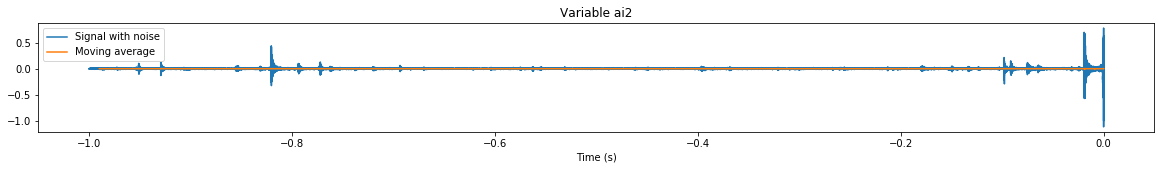

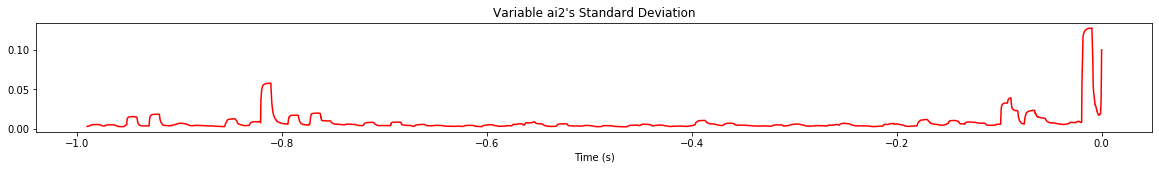

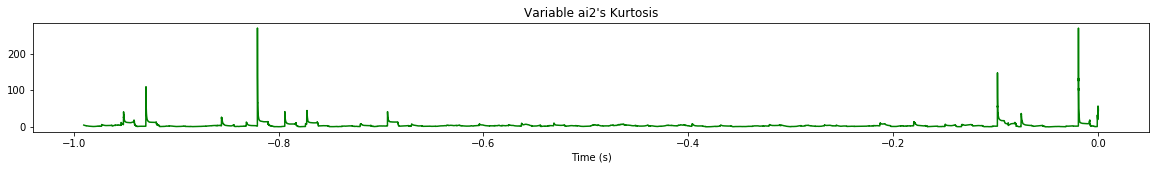

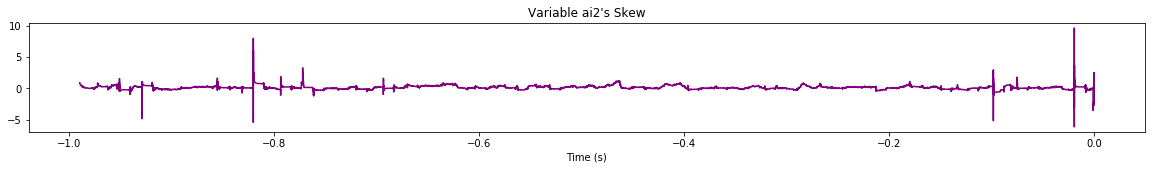

Flushing input history
Flushing input history


In [3]:
load_and_plot("./data/Ramp4/", "ai2", time_range = (-1, 0), stat = True, window = 1000)

ai2


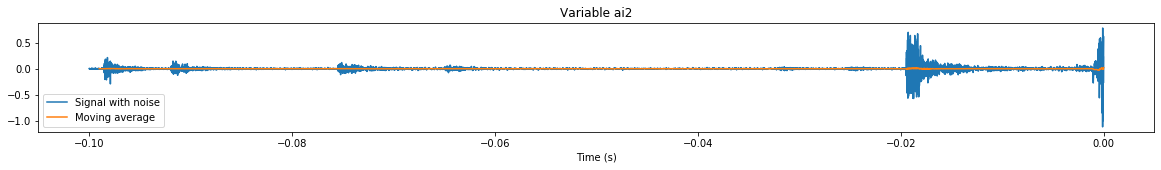

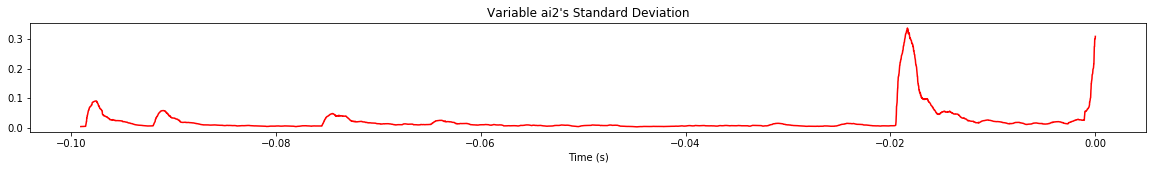

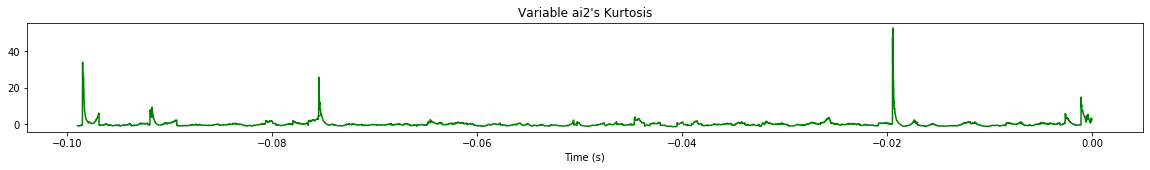

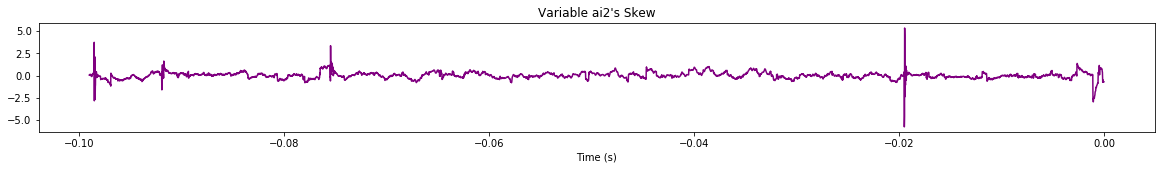

Flushing input history
Flushing input history


In [7]:
load_and_plot("./data/Ramp4/", "ai2", time_range = (-100e-3, 0), stat = True, window = 100)

ai1


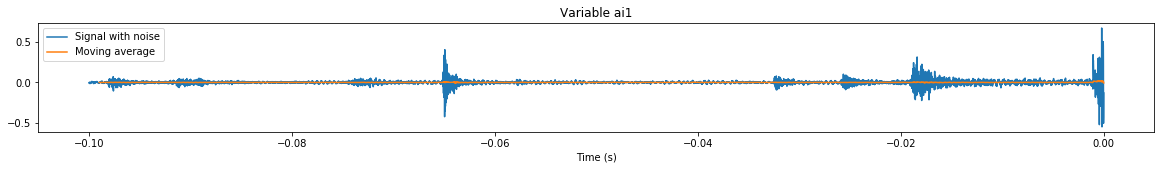

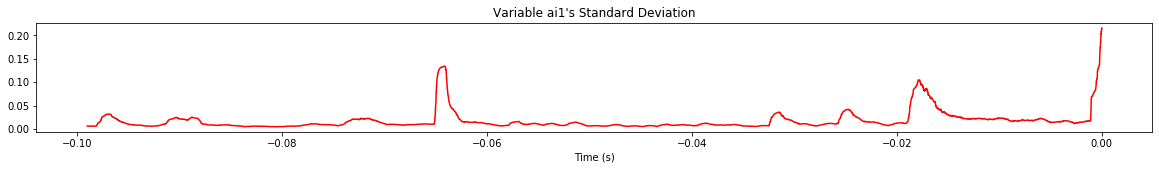

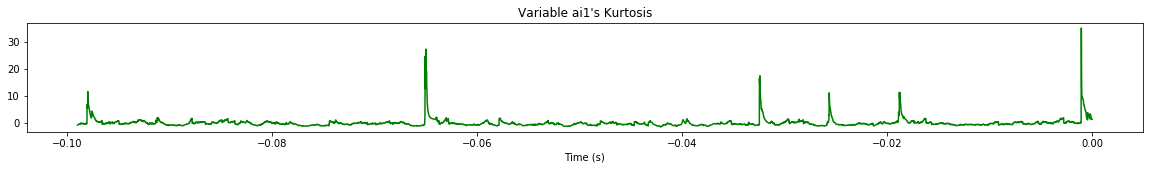

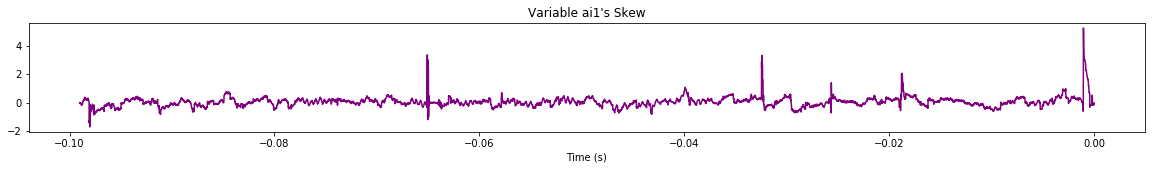

Flushing input history
Flushing input history


In [8]:
load_and_plot("./data/Ramp4/", "ai1", time_range = (-100e-3, 0), stat = True, window = 100)

ai0


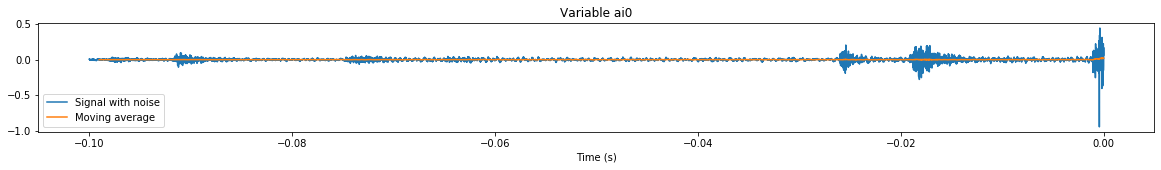

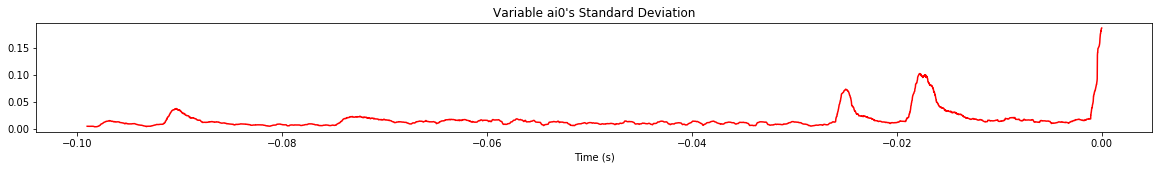

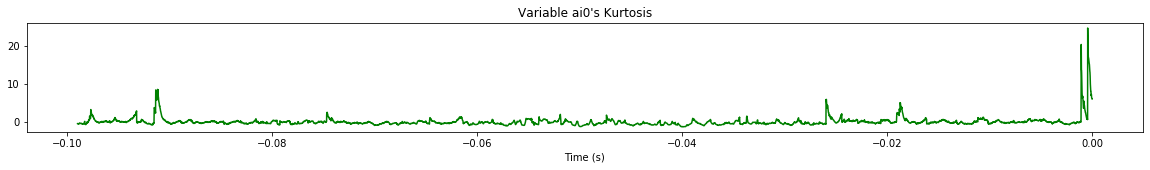

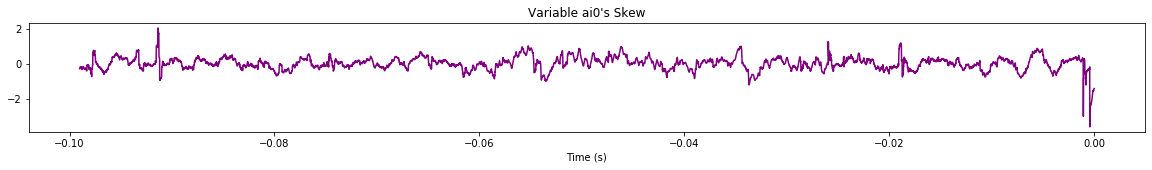

Flushing input history
Flushing input history


In [9]:
load_and_plot("./data/Ramp4/", "ai0", time_range = (-100e-3, 0), stat = True, window = 100)

ai3


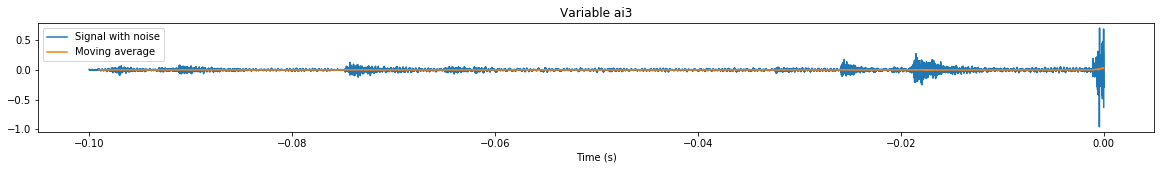

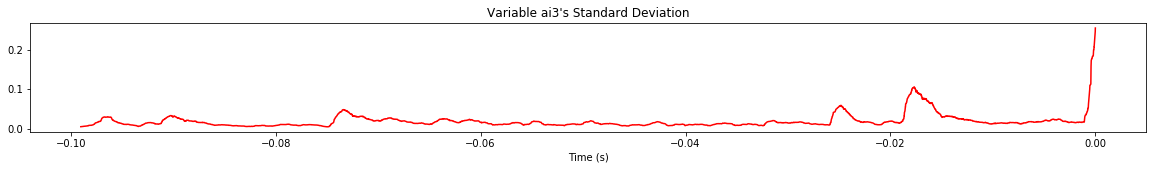

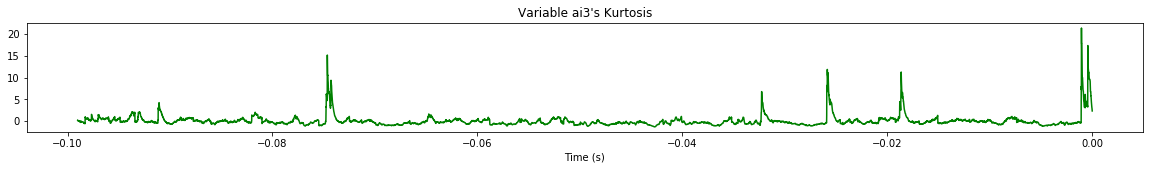

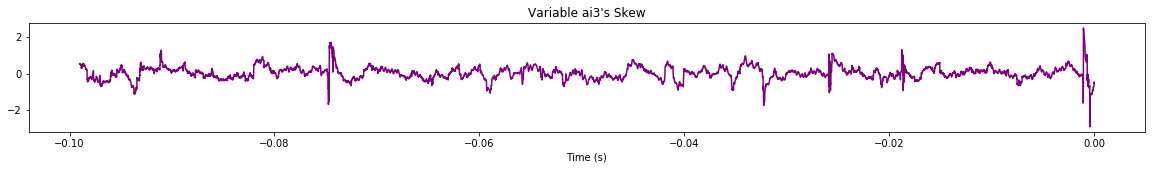

Flushing input history
Flushing input history


In [10]:
load_and_plot("./data/Ramp4/", "ai3", time_range = (-100e-3, 0), stat = True, window = 100)

ai4


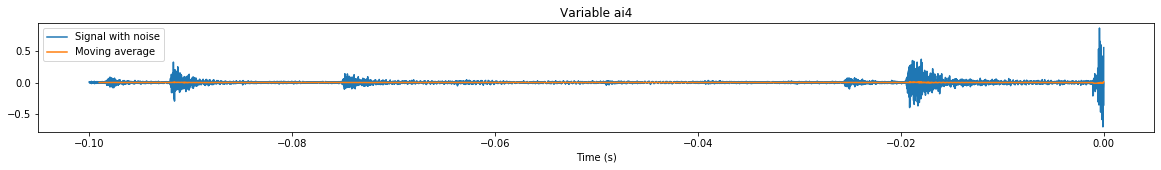

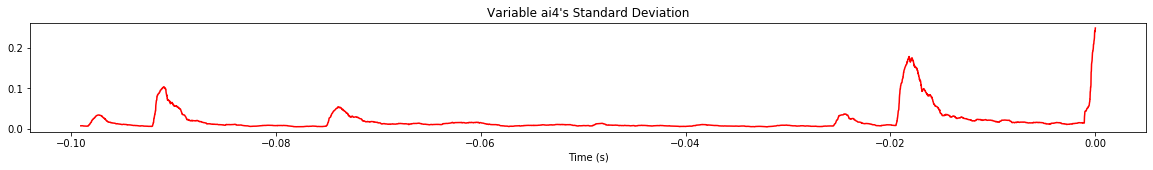

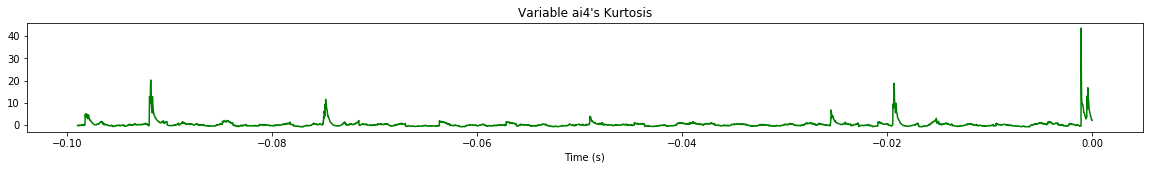

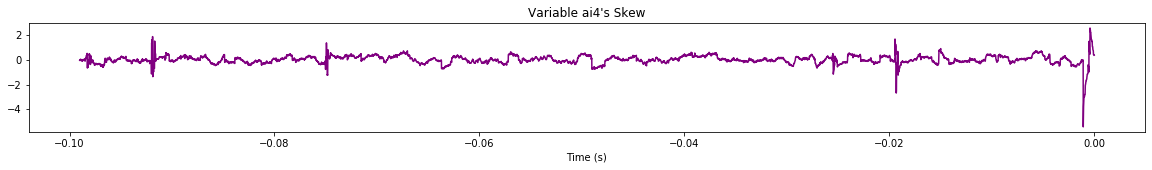

Flushing input history
Flushing input history


In [11]:
load_and_plot("./data/Ramp4/", "ai4", time_range = (-100e-3, 0), stat = True, window = 100)

In [6]:
#load_and_plot("./data/Ramp4/", "ai3", time_range = (-50, 0), stat = True, window = 1000000)

In [3]:
#load_and_plot("./data/Ramp4/", "ai2")

In [39]:
#plot_distribution("./data/Ramp4/", "ai2", time_range = (-8,-6))

In [17]:
17451/3000

5.817

In [3]:
ai7 = load_channel_and_time("./data/Ramp4/", "ai7")

In [4]:
ai7[ai7["time"] == 0]

ai7  time
75480494  5.844055   0.0

In [18]:
ai7[(ai7["ai7"]> 5.817)]

ai7     time
75176927  5.817016 -3.03567
75177480  5.817066 -3.03014
75178459  5.817058 -3.02035
75178593  5.817120 -3.01901
75178860  5.817003 -3.01634
...            ...      ...
75480591  5.818447  0.00097
75480592  5.818030  0.00098
75480593  5.817759  0.00099
75480594  5.817402  0.00100
75480595  5.817057  0.00101

[292497 rows x 2 columns]

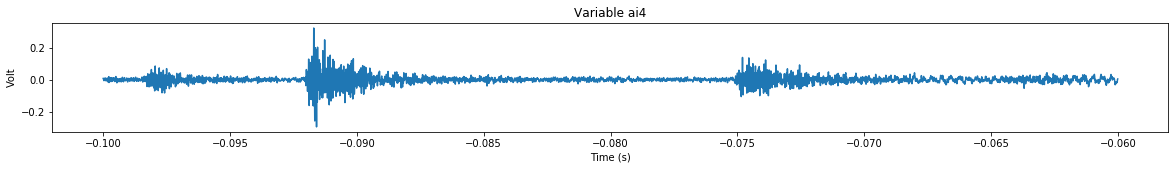

Flushing input history
Flushing input history


In [10]:
load_and_plot("./data/Ramp4/", "ai4", time_range = (-100e-3, -60e-3))

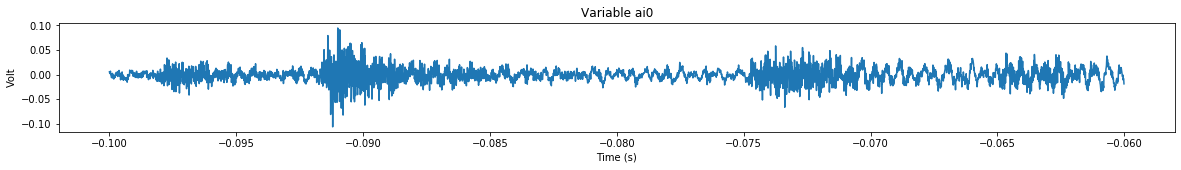

Flushing input history
Flushing input history


In [11]:
load_and_plot("./data/Ramp4/", "ai0", time_range = (-100e-3, -60e-3))

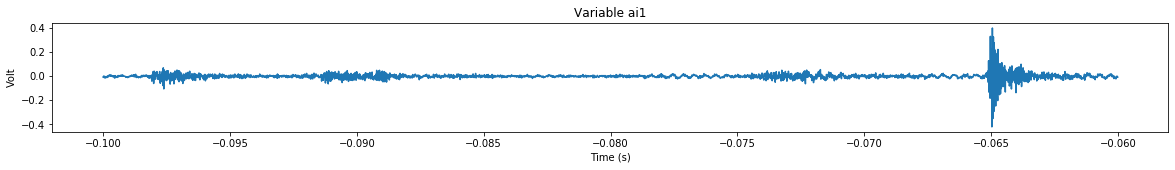

Flushing input history
Flushing input history


In [12]:
load_and_plot("./data/Ramp4/", "ai1", time_range = (-100e-3, -60e-3))

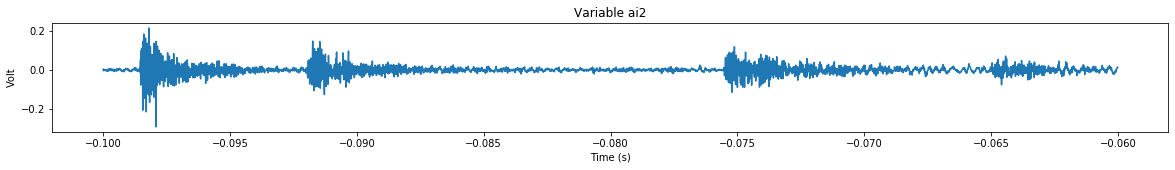

Flushing input history
Flushing input history


In [13]:
load_and_plot("./data/Ramp4/", "ai2", time_range = (-100e-3, -60e-3))

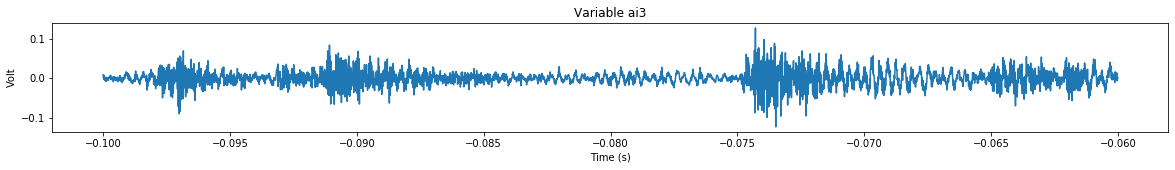

Flushing input history
Flushing input history


In [14]:
load_and_plot("./data/Ramp4/", "ai3", time_range = (-100e-3, -60e-3))

## MQXFS1D -- 25.Apr.2018 18:22 -- Ramp 5

### 1.1 Normal quench data 

In [23]:
quench5 = all_quench['mqxfs1d.Quench.180425182230']

In [31]:
#plot_statistics(quench5, variables = ['V1_VoAqdHcoilHcoilM_1'], time_range = (-20e-3,0), window = 10)

### 1.2 Acoustic data

ai2


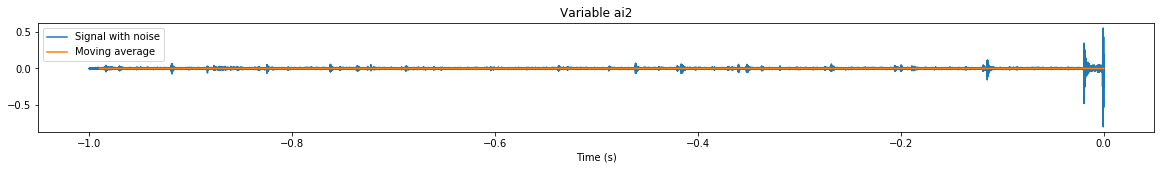

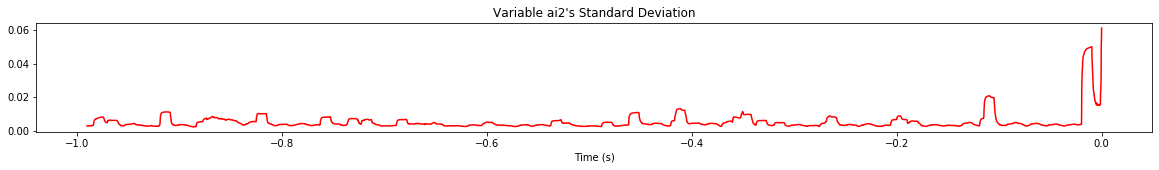

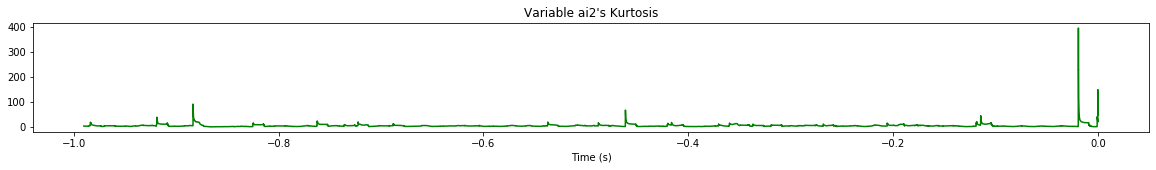

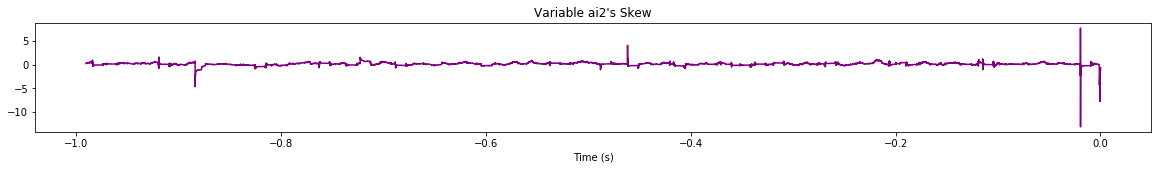

Flushing input history
Flushing input history


In [5]:
load_and_plot("./data/Ramp5/", "ai2", time_range = (-1,0), stat = True, window = 1000)

ai2


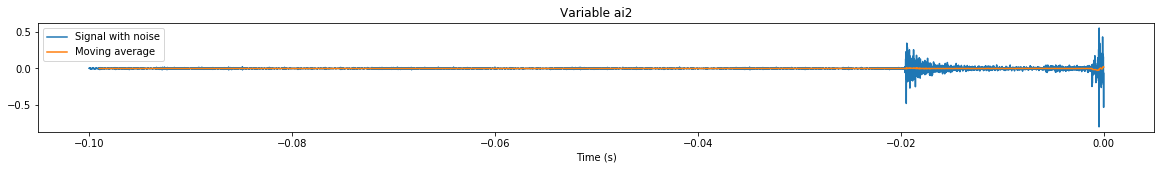

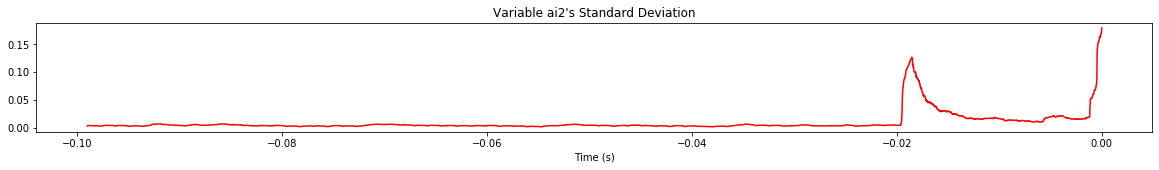

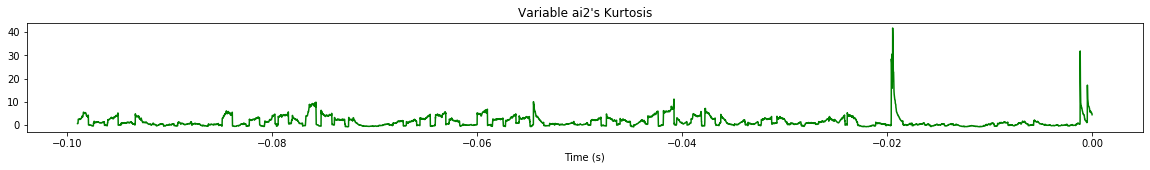

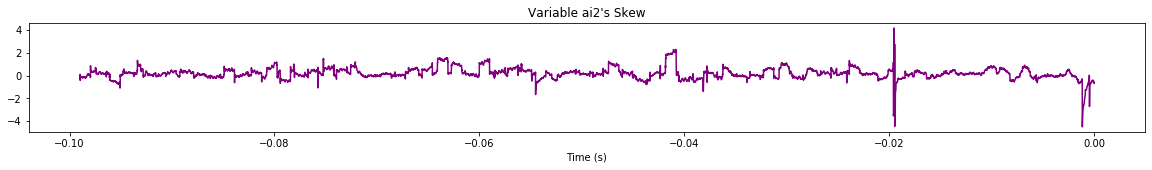

Flushing input history
Flushing input history


In [6]:
load_and_plot("./data/Ramp5/", "ai2", time_range = (-100e-3,0), stat = True, window = 100)

ai1


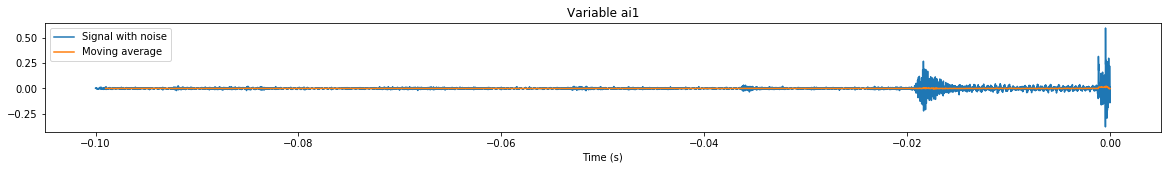

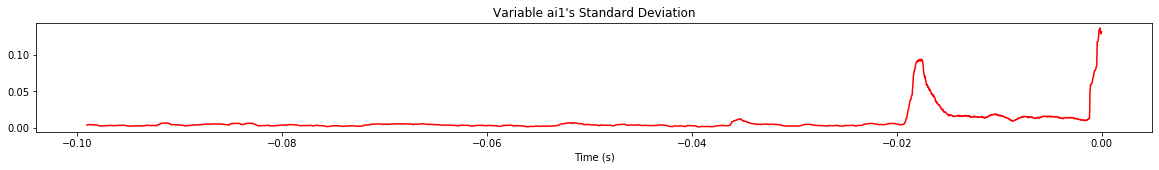

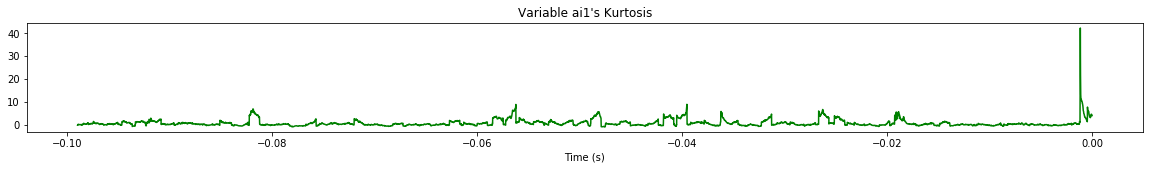

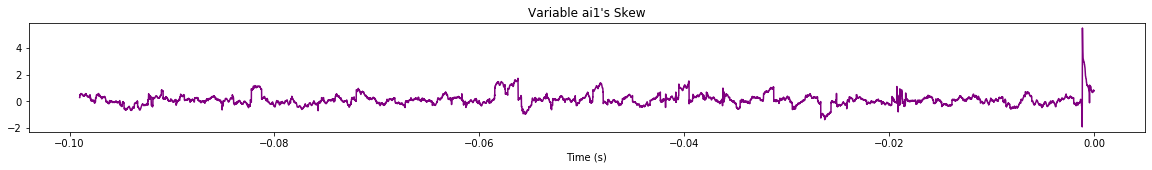

Flushing input history
Flushing input history


In [12]:
load_and_plot("./data/Ramp5/", "ai1", time_range = (-100e-3,0), stat = True, window = 100)

ai0


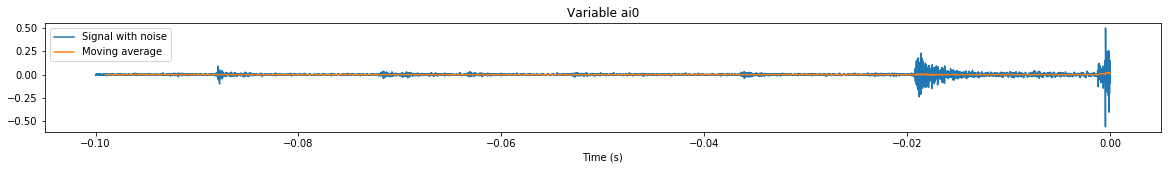

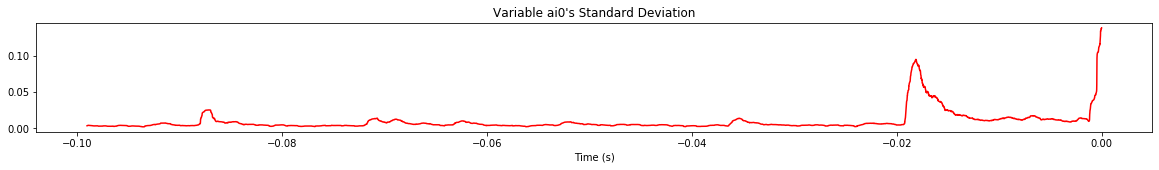

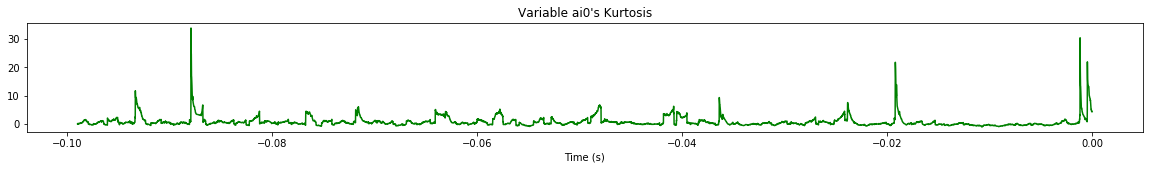

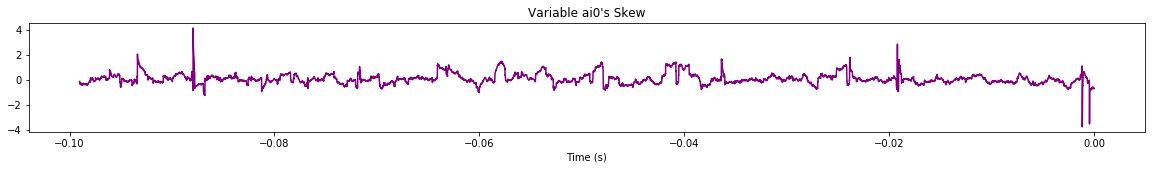

Flushing input history
Flushing input history


In [13]:
load_and_plot("./data/Ramp5/", "ai0", time_range = (-100e-3,0), stat = True, window = 100)

ai3


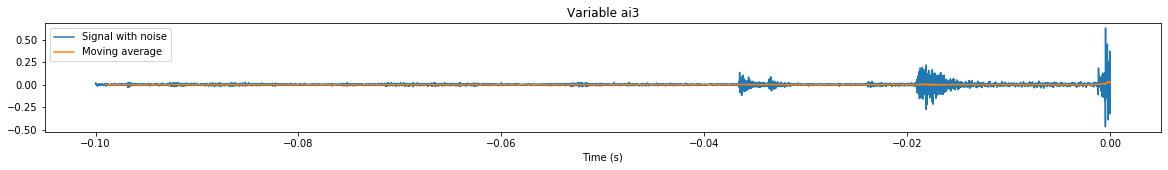

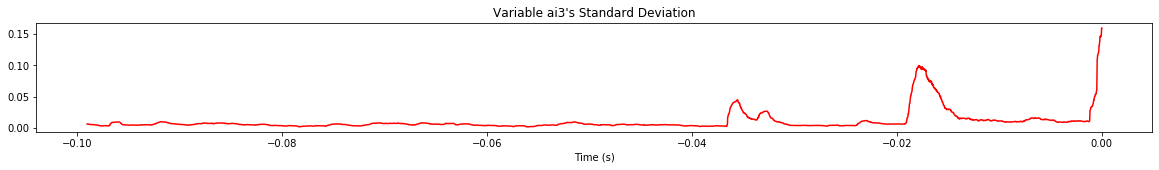

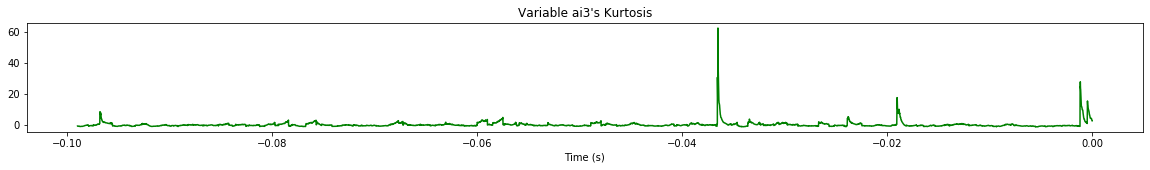

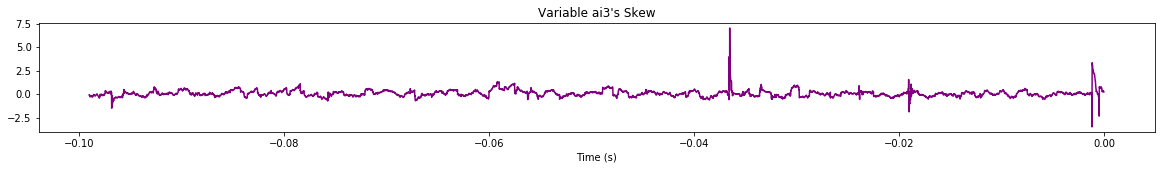

Flushing input history
Flushing input history


In [14]:
load_and_plot("./data/Ramp5/", "ai3", time_range = (-100e-3,0), stat = True, window = 100)

ai4


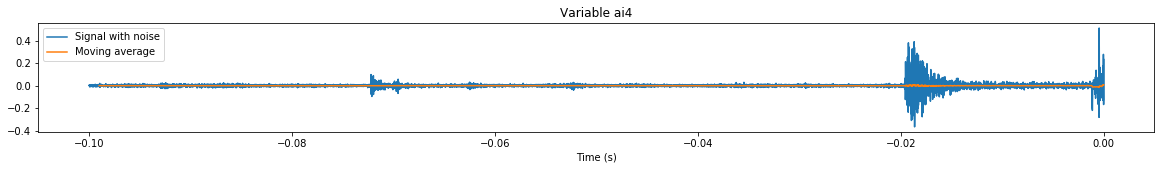

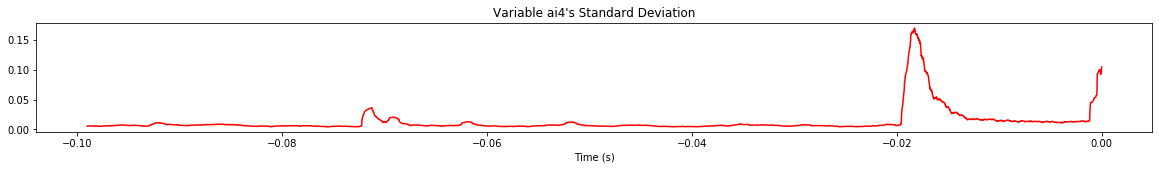

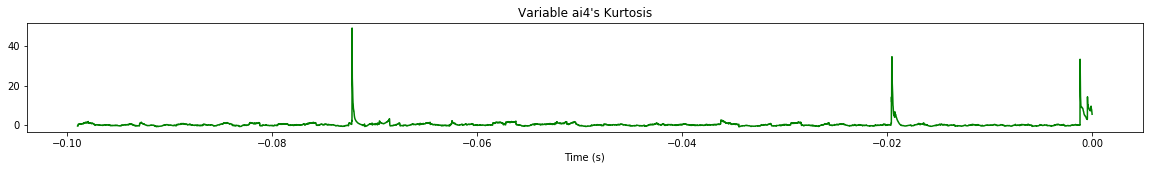

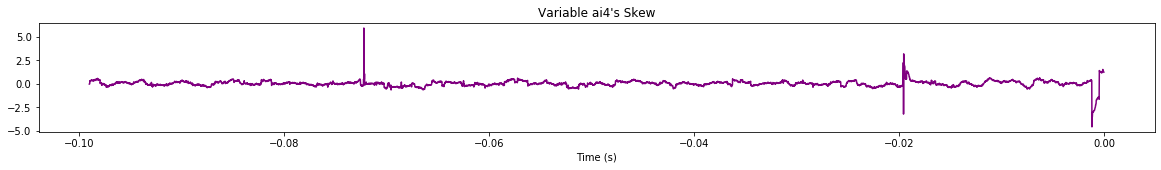

Flushing input history
Flushing input history


In [15]:
load_and_plot("./data/Ramp5/", "ai4", time_range = (-100e-3,0), stat = True, window = 100)

In [8]:
ai7[ai7["time"] == 10e-5]

ai7    time
64714328  5.842706  0.0001

In [ ]:
5.844055

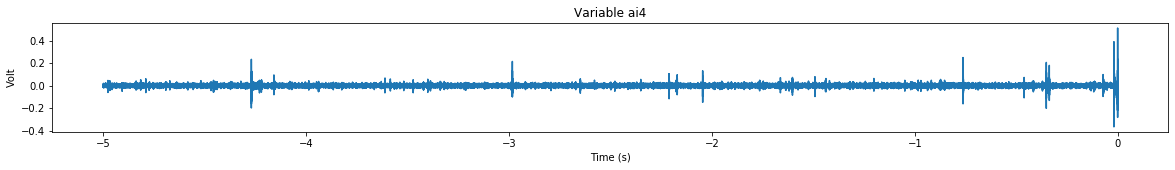

Flushing input history
Flushing input history


In [20]:
load_and_plot("./data/Ramp5/", "ai4", time_range = (-5, 0))

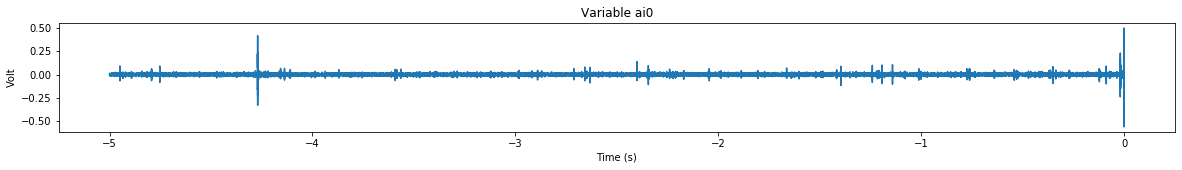

Flushing input history
Flushing input history


In [21]:
load_and_plot("./data/Ramp5/", "ai0", time_range = (-5, 0))

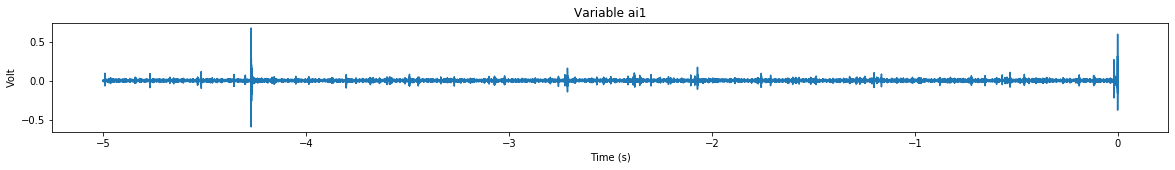

Flushing input history
Flushing input history


In [22]:
load_and_plot("./data/Ramp5/", "ai1", time_range = (-5, 0))

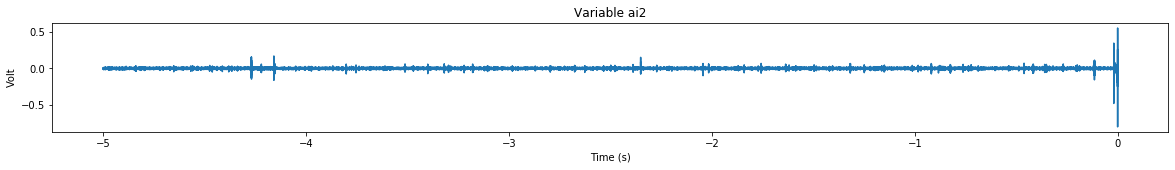

Flushing input history
Flushing input history


In [23]:
load_and_plot("./data/Ramp5/", "ai2", time_range = (-5, 0))

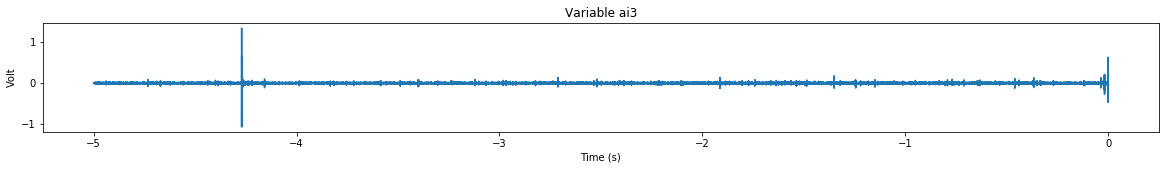

Flushing input history
Flushing input history


In [24]:
load_and_plot("./data/Ramp5/", "ai3", time_range = (-5, 0))

## MQXFS1D -- 27.Apr.2018 15:45 -- Ramp 12

### 12.1 normal quench data

In [6]:
#quench12 = all_quench['mqxfs1d.Quench.180427154529']

In [11]:
#plot_statistics(quench12, time_range = (-20e-3,20e-3), window = 10)

ai0


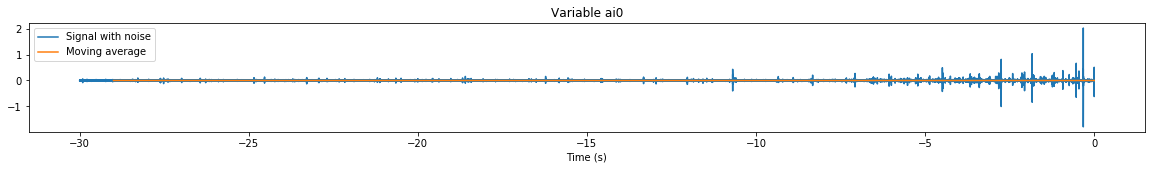

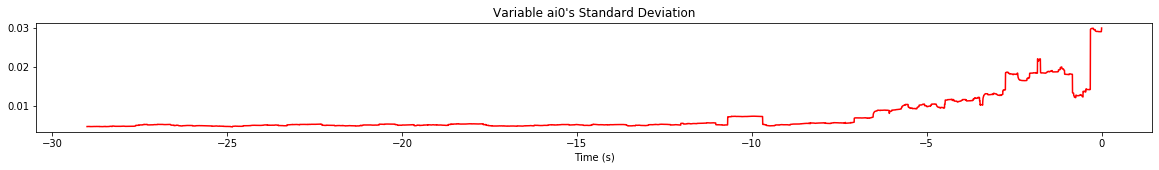

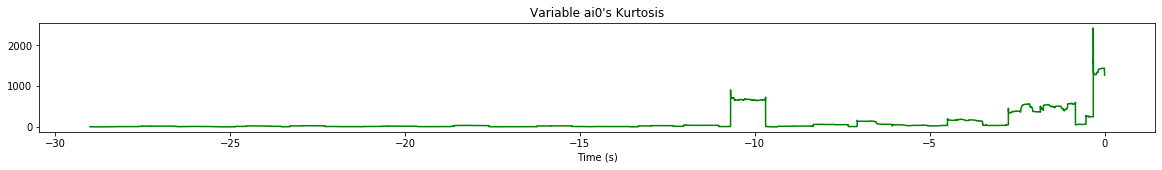

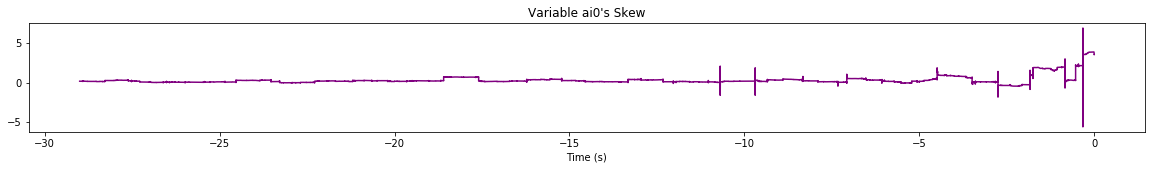

Flushing input history
Flushing input history


In [25]:
load_and_plot("./data/Ramp12d/", "ai0", time_range = (-30, 0), stat = True, window = 100000)

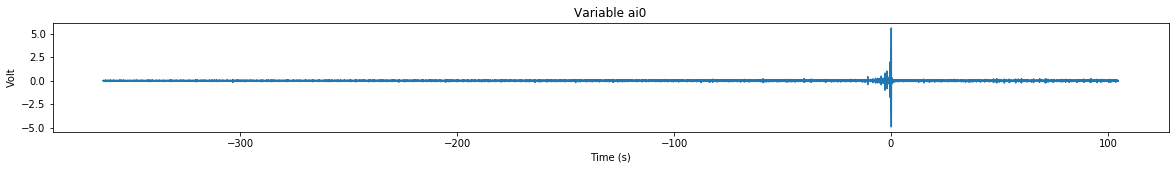

Flushing input history
Flushing input history


In [18]:
load_and_plot("./data/Ramp12d/", "ai0")

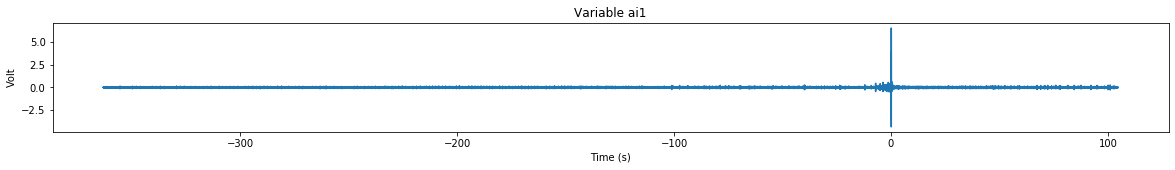

Flushing input history
Flushing input history


In [19]:
load_and_plot("./data/Ramp12d/", "ai1")

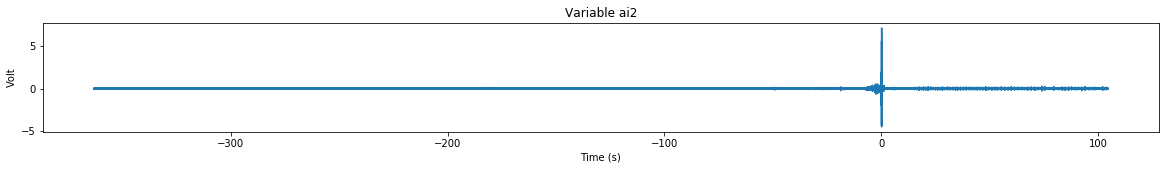

Flushing input history
Flushing input history


In [20]:
load_and_plot("./data/Ramp12d/", "ai2")

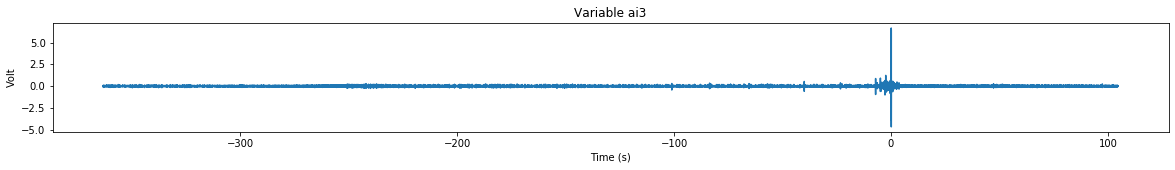

Flushing input history
Flushing input history


In [21]:
load_and_plot("./data/Ramp12d/", "ai3")

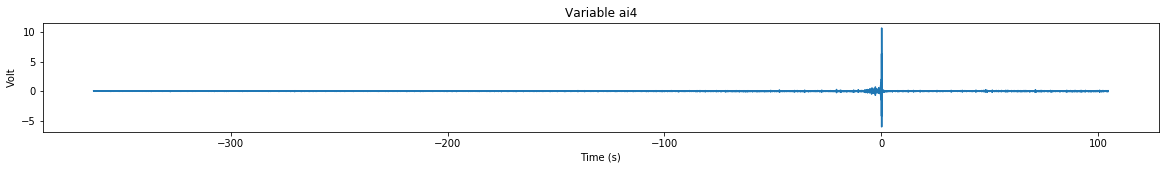

Flushing input history
Flushing input history


In [22]:
load_and_plot("./data/Ramp12d/", "ai4")

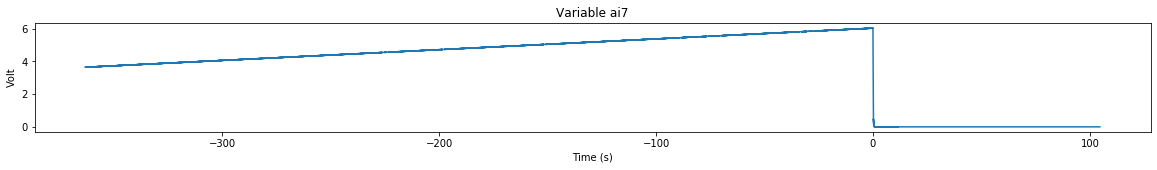

Flushing input history
Flushing input history


In [23]:
load_and_plot("./data/Ramp12d/", "ai7")

In [26]:
data = load_channel_and_time("./data/Ramp12d/", "ai7")

In [27]:
data[data['time'] == 0]

ai7  time
36316462  6.045471   0.0

## MQXFS1D -- 24.May.2018 15:24-- Ramp 19

### 19.1 Main trip data

In [5]:
#quench19 = all_quench['mqxfs1d.Quench.180524152407']

In [8]:
#plot_statistics(quench19, variables = ['V1_VoAqdHcoilHcoilM_1'], time_range = (-1,1), window = 10)

### 19.2 Acoustic data

In [3]:
#ramp19_path = "/uscmst1b_scratch/lpc1/lpcmuon/stoyan/data/mqxfs1d/Acoustics/2018May24/Ramp19.tdms"

#break_tdms_to_files(ramp19_path)

In [4]:
#calculate_time("./data/Ramp19/")

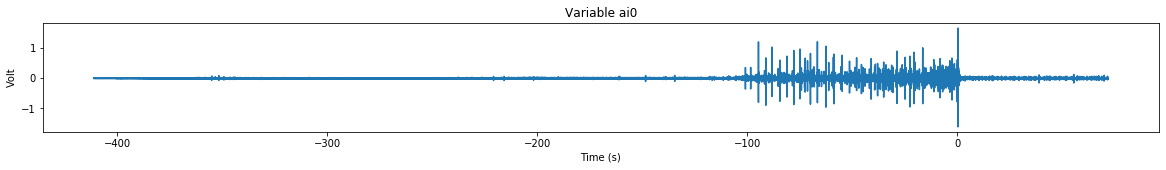

Flushing input history
Flushing input history


In [28]:
load_and_plot("./data/Ramp19/", "ai0")

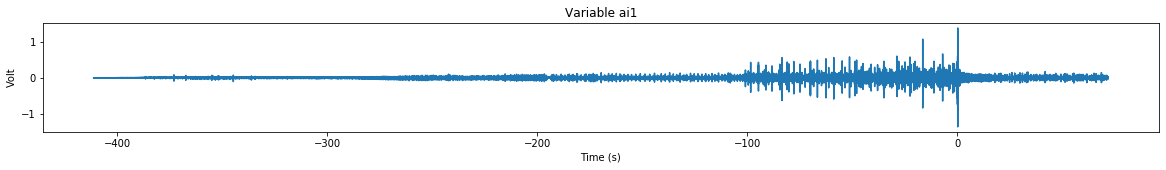

Flushing input history
Flushing input history


In [29]:
load_and_plot("./data/Ramp19/", "ai1")

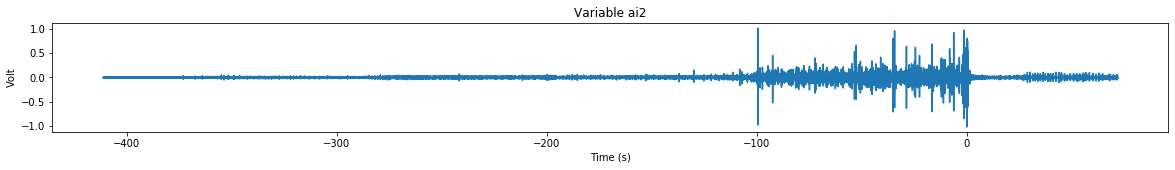

Flushing input history
Flushing input history


In [30]:
load_and_plot("./data/Ramp19/", "ai2")

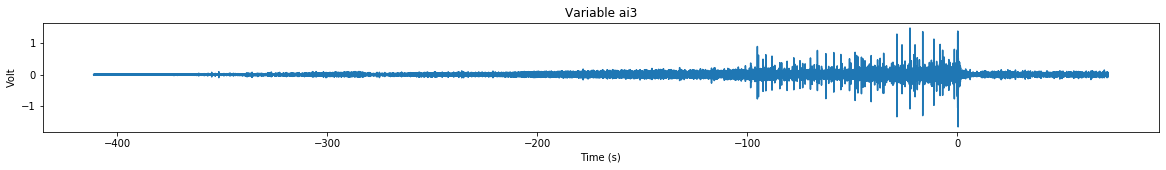

Flushing input history
Flushing input history


In [31]:
load_and_plot("./data/Ramp19/", "ai3")

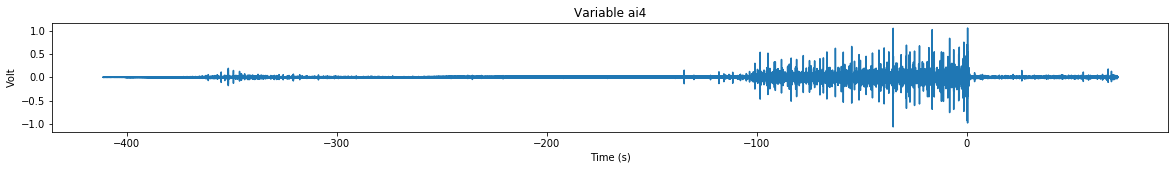

Flushing input history
Flushing input history


In [32]:
load_and_plot("./data/Ramp19/", "ai4")

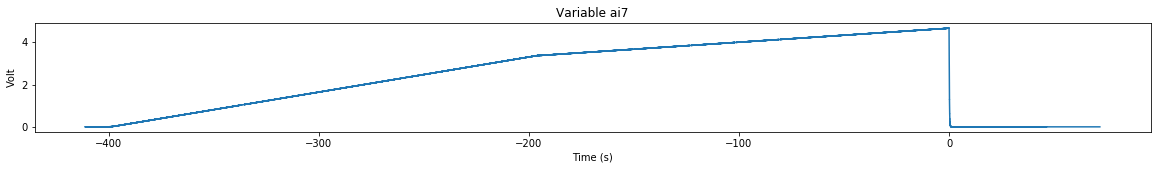

Flushing input history
Flushing input history


In [33]:
load_and_plot("./data/Ramp19/", "ai7")

In [34]:
data = load_channel_and_time("./data/Ramp19/", "ai7")

In [35]:
data[data['time'] == 0]

ai7  time
41121011  4.672324   0.0

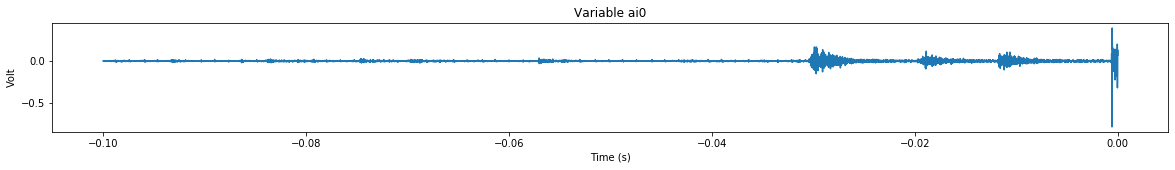

Flushing input history
Flushing input history


In [4]:
load_and_plot("./data/Ramp19/", "ai0", time_range= (-100e-3,0))

## MQXFS1D -- 24.May.2018 16:53 -- Ramp 20

### 20.1 Main quench data

In [29]:
#quench20 = all_quench['mqxfs1d.Quench.180524165335']

In [30]:
#plot_statistics(quench20, variables = ['V1_VoAqdHcoilHcoilM_1'], time_range = (-20e-3,0), window = 10)

### 20.2 Acoustic data

ai2


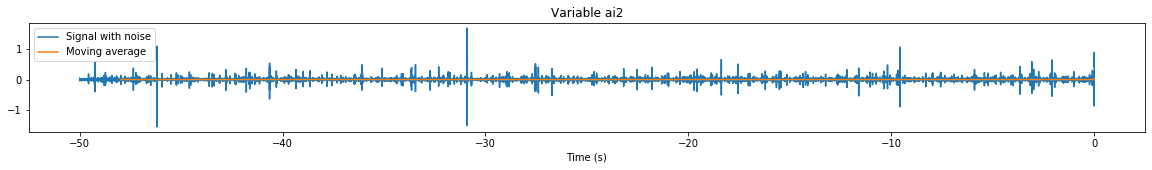

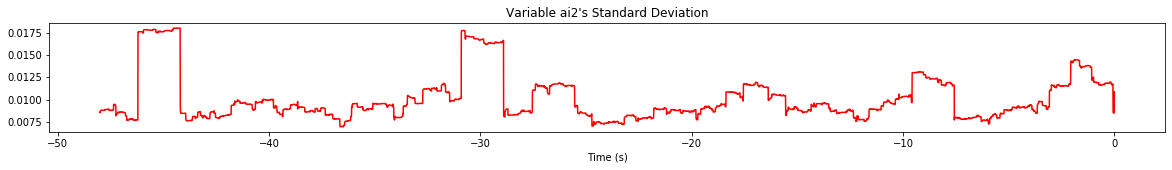

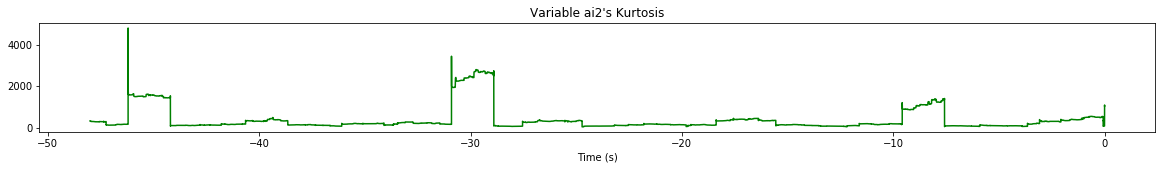

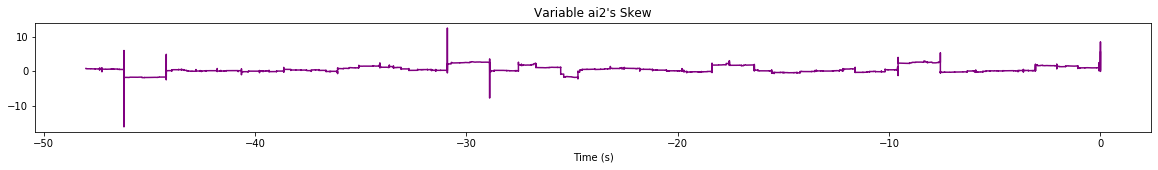

Flushing input history
Flushing input history


In [20]:
load_and_plot("./data/Ramp20/", "ai2", time_range = (-50, 0), stat = True, window = 200000)

Flushing input history


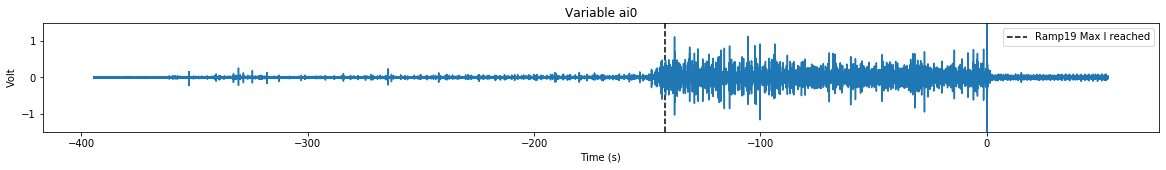

Flushing input history
Flushing input history


In [43]:
load_and_plot("./data/Ramp20/", "ai0", max_current = True)

Flushing input history


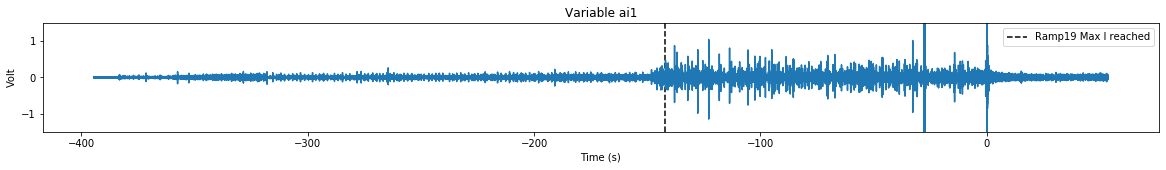

Flushing input history
Flushing input history


In [44]:
load_and_plot("./data/Ramp20/", "ai1", max_current = True)

Flushing input history


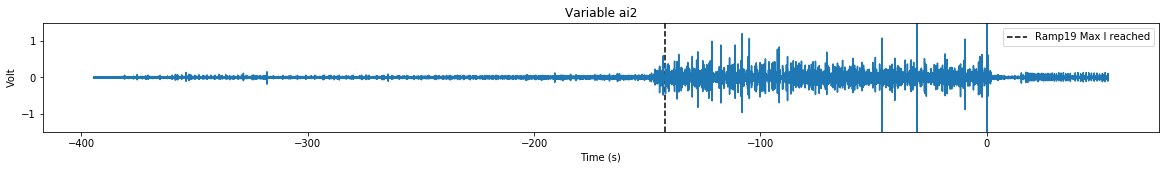

Flushing input history
Flushing input history


In [45]:
load_and_plot("./data/Ramp20/", "ai2", max_current = True)

Flushing input history


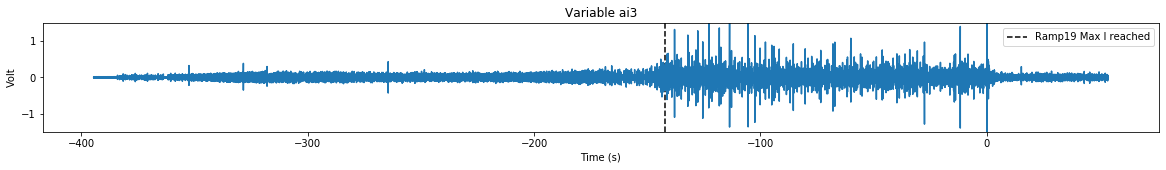

Flushing input history
Flushing input history


In [46]:
load_and_plot("./data/Ramp20/", "ai3", max_current = True)

Flushing input history


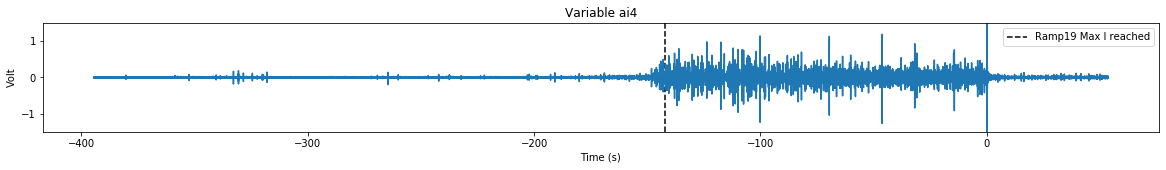

Flushing input history
Flushing input history


In [47]:
load_and_plot("./data/Ramp20/", "ai4", max_current = True)

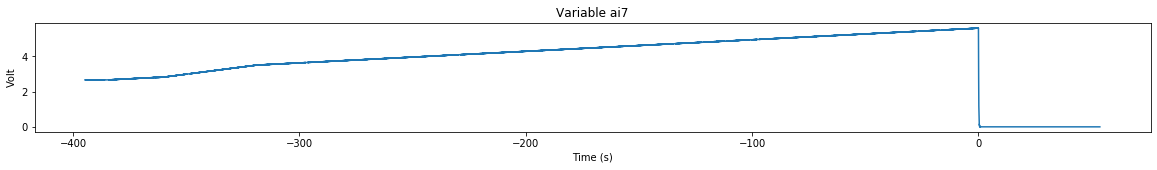

Flushing input history
Flushing input history


In [19]:
load_and_plot("./data/Ramp20/", "ai7")

In [20]:
data = load_channel_and_time("./data/Ramp20/", "ai7")

print(data[data['time'] == 0])

               ai7  time
39454649  5.615348   0.0


## MQXFS1D -- 25.May.2018 9:35-- Ramp 21

### 21.1 Main quench data

In [6]:
#quench21 = all_quench['mqxfs1d.Quench.180525093547']

In [9]:
#plot_statistics(quench21, time_range = (-20e-3,0), window = 10)

### 21.2 Acoustic data

Flushing input history
Flushing input history


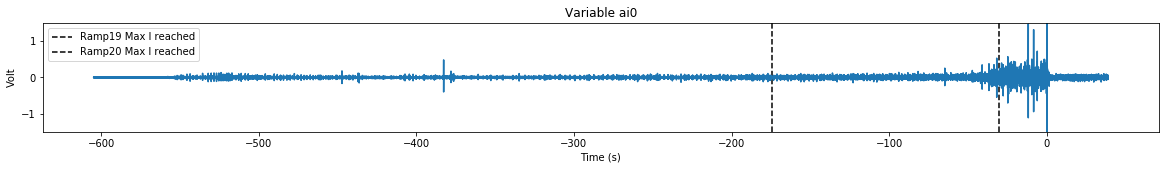

Flushing input history
Flushing input history


In [14]:
load_and_plot("./data/Ramp21/", "ai0", max_current = True)

Flushing input history
Flushing input history


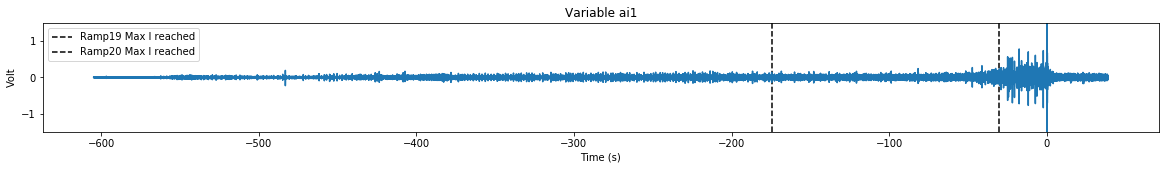

Flushing input history
Flushing input history


In [15]:
load_and_plot("./data/Ramp21/", "ai1", max_current = True)

Flushing input history
Flushing input history


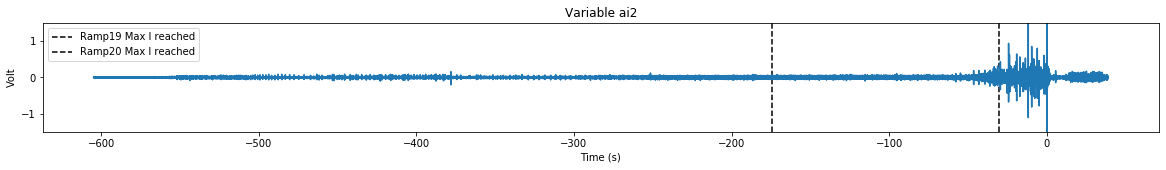

Flushing input history
Flushing input history


In [16]:
load_and_plot("./data/Ramp21/", "ai2", max_current = True)

Flushing input history
Flushing input history


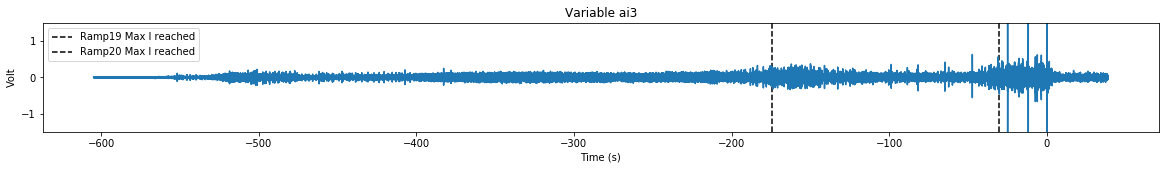

Flushing input history
Flushing input history


In [17]:
load_and_plot("./data/Ramp21/", "ai3", max_current = True)

Flushing input history
Flushing input history


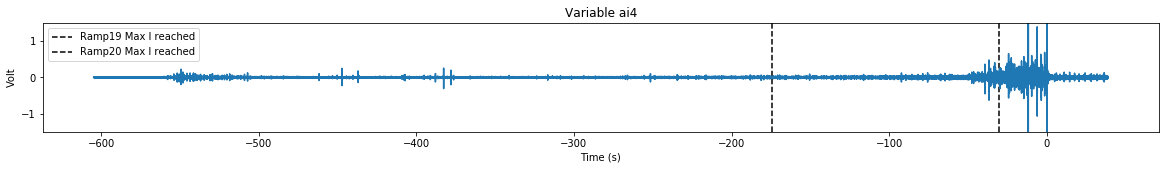

Flushing input history
Flushing input history


In [18]:
load_and_plot("./data/Ramp21/", "ai4", max_current = True)

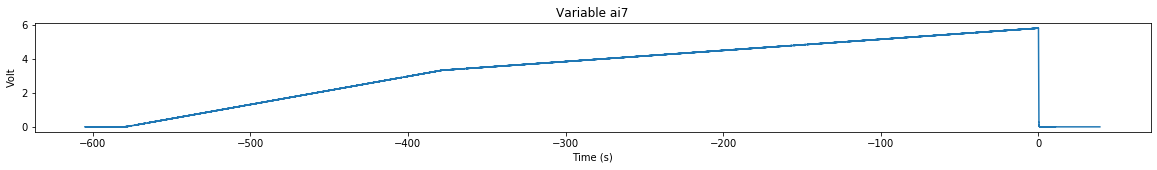

Flushing input history
Flushing input history


In [19]:
load_and_plot("./data/Ramp21/", "ai7")

In [20]:
data = load_channel_and_time("./data/Ramp21/", "ai7")

print(data[data['time'] == 0])

               ai7  time
60467523  5.822541   0.0


## Ramp 22 -- MQXFS1D -- 25.May.2018 12:50

### 22.1 Main quench data

In [21]:
#quench22 = all_quench['mqxfs1d.Quench.180525125034']

In [24]:
#plot_statistics(quench22, variables = ['V1_VoAqdHcoilHcoilM_1'], time_range = (-20e-3,0), window = 10)

### 22.2 Acoustic data

Flushing input history
Flushing input history


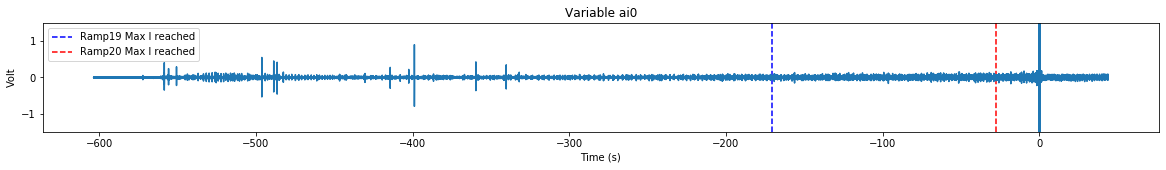

Flushing input history
Flushing input history


In [8]:
load_and_plot("./data/Ramp22/", "ai0", max_current = True)

Flushing input history
Flushing input history


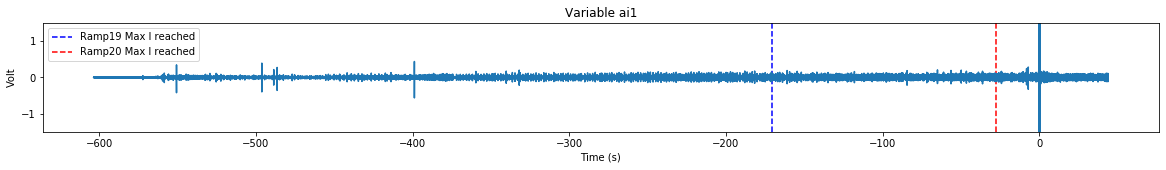

Flushing input history
Flushing input history


In [9]:
load_and_plot("./data/Ramp22/", "ai1", max_current = True)

Flushing input history
Flushing input history


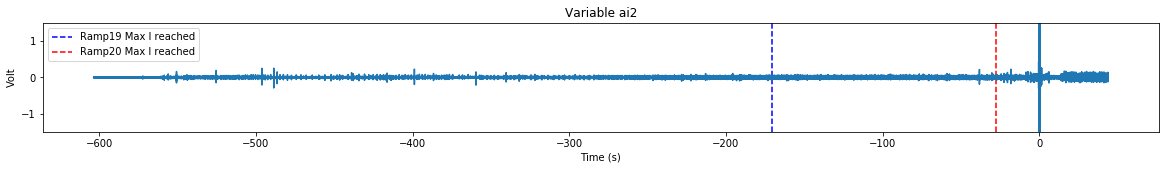

Flushing input history
Flushing input history


In [10]:
load_and_plot("./data/Ramp22/", "ai2", max_current = True)

Flushing input history
Flushing input history


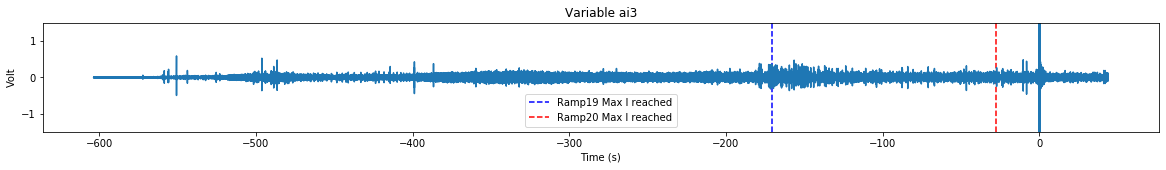

Flushing input history
Flushing input history


In [11]:
load_and_plot("./data/Ramp22/", "ai3", max_current = True)

Flushing input history
Flushing input history


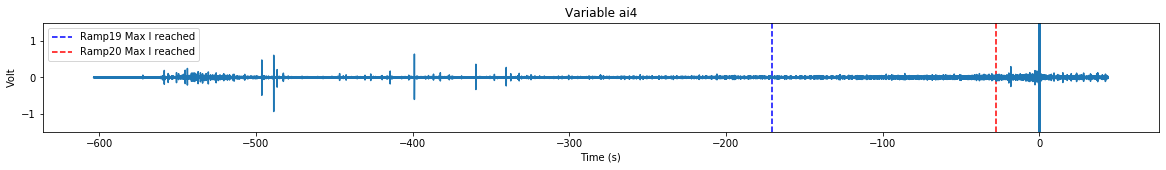

Flushing input history
Flushing input history


In [12]:
load_and_plot("./data/Ramp22/", "ai4", max_current = True)

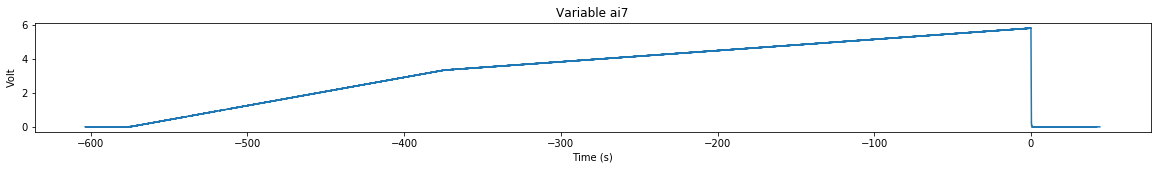

Flushing input history
Flushing input history


In [13]:
load_and_plot("./data/Ramp22/", "ai7")

In [6]:
data = load_channel_and_time("./data/Ramp22/", "ai7")

print(data[data['time'] == 0])

               ai7  time
60350721  5.804141   0.0


## Ramp 23 -- MQXFS1D -- 25.May.2018 17:20

### 23.1 Main quench data

In [7]:
#quench23 = all_quench['mqxfs1d.Quench.180525172022']

In [8]:
#plot_statistics(quench23, time_range = (-20e-3,0), window = 10)

### 23.2 Acoustic data

Flushing input history
Flushing input history
Flushing input history
Flushing input history


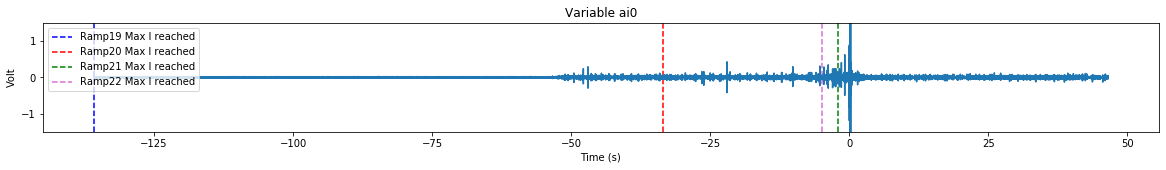

Flushing input history
Flushing input history


In [18]:
load_and_plot("./data/Ramp23/", "ai0", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history


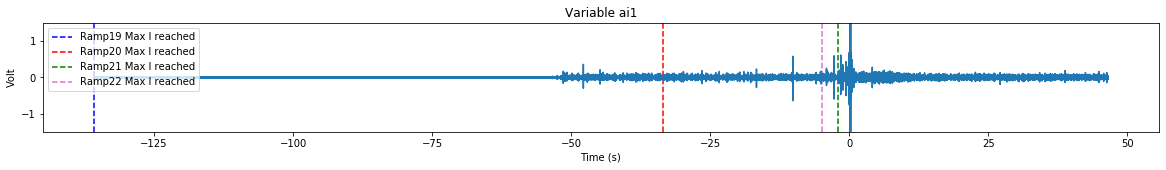

Flushing input history
Flushing input history


In [19]:
load_and_plot("./data/Ramp23/", "ai1", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history


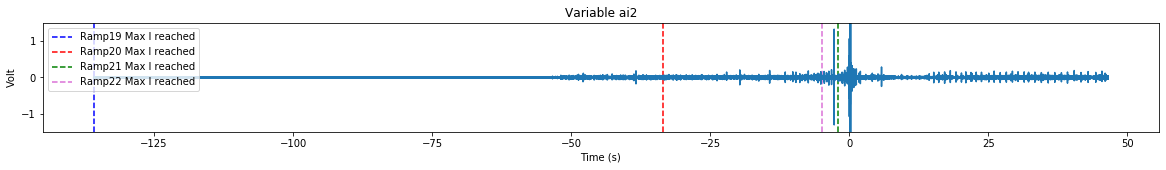

Flushing input history
Flushing input history


In [20]:
load_and_plot("./data/Ramp23/", "ai2", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history


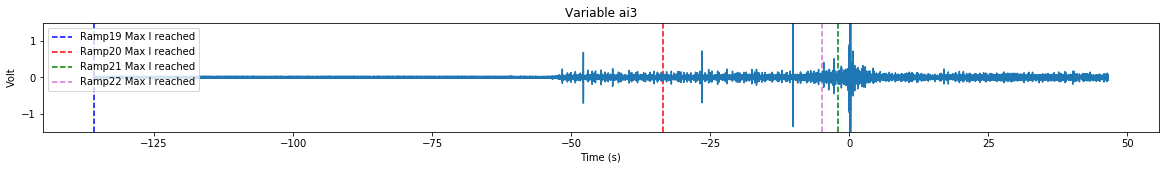

Flushing input history
Flushing input history


In [21]:
load_and_plot("./data/Ramp23/", "ai3", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history


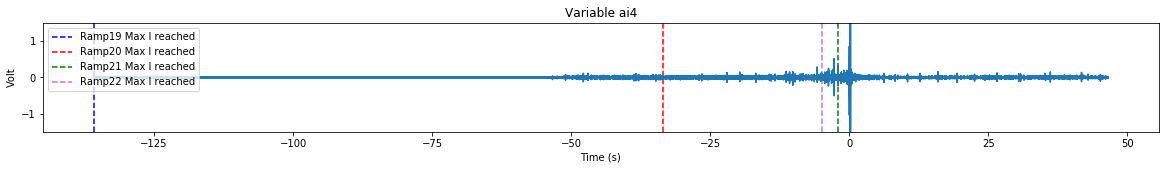

Flushing input history
Flushing input history


In [22]:
load_and_plot("./data/Ramp23/", "ai4", max_current = True)

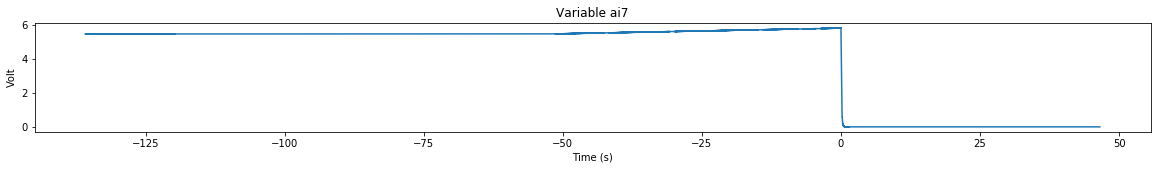

Flushing input history
Flushing input history


In [23]:
load_and_plot("./data/Ramp23/", "ai7")

In [11]:
data = load_channel_and_time("./data/Ramp23/", "ai7")

print(data[data['time'] == 0])

               ai7  time
13586896  5.843059   0.0


## Ramp 24 -- MQXFS1D -- 29.May.2018 12:33

### 24.1 Main quench data

In [27]:
#quench24 = all_quench['mqxfs1d.Quench.180529123355']

In [28]:
#plot_statistics(quench24, variables = ["V1_VoAqdHcoilHcoilM_1"], time_range = (-20e-3,0), window = 10)

### 24.2 Acoustic data

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


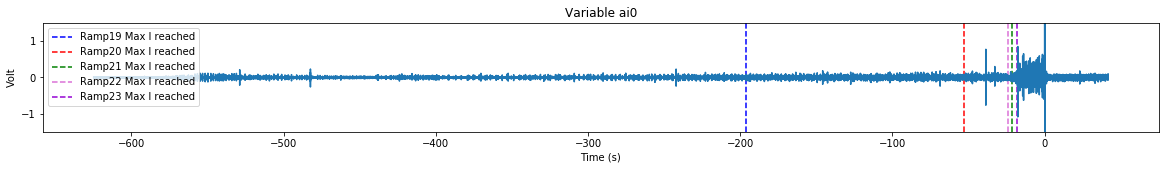

Flushing input history
Flushing input history


In [33]:
load_and_plot("./data/Ramp24/", "ai0", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


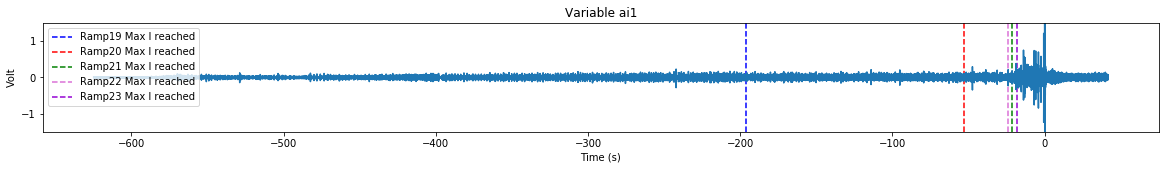

Flushing input history
Flushing input history


In [34]:
load_and_plot("./data/Ramp24/", "ai1", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


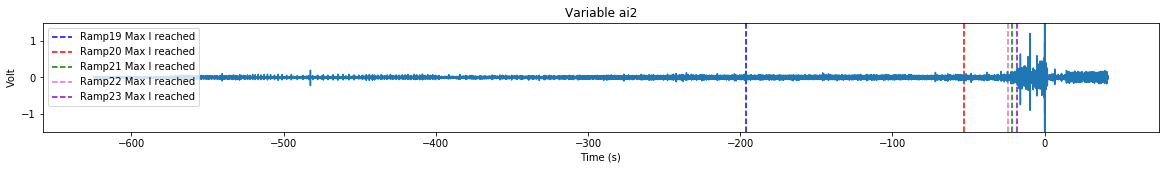

Flushing input history
Flushing input history


In [35]:
load_and_plot("./data/Ramp24/", "ai2", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


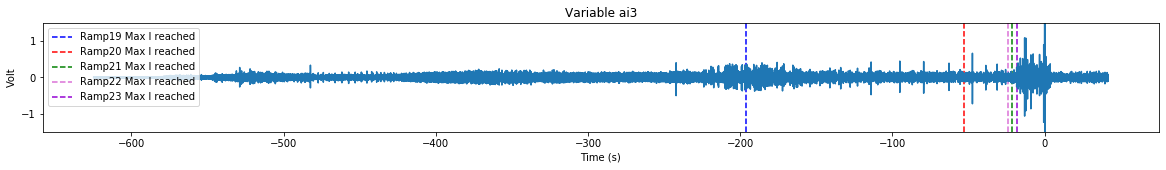

Flushing input history
Flushing input history


In [36]:
load_and_plot("./data/Ramp24/", "ai3", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


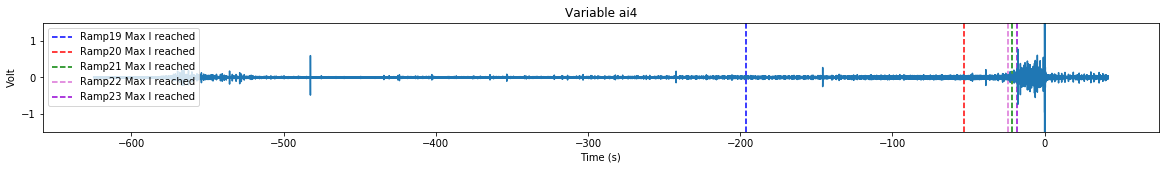

Flushing input history
Flushing input history


In [37]:
load_and_plot("./data/Ramp24/", "ai4", max_current = True)

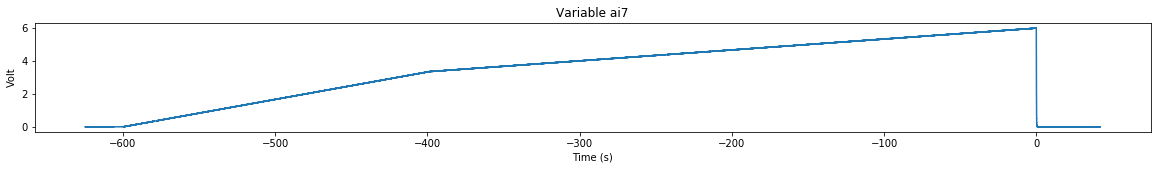

Flushing input history
Flushing input history


In [38]:
load_and_plot("./data/Ramp24/", "ai7")

In [32]:
data = load_channel_and_time("./data/Ramp24/", "ai7")

print(data[data['time'] == 0])

               ai7  time
62470980  5.970426   0.0


## Ramp 25 -- MQXFS1D -- 29.May.2018 15:33

### 25.1 Main quench data

In [40]:
#quench25 = all_quench['mqxfs1d.Quench.180529153341']

In [43]:
#plot_statistics(quench25, time_range = (-20e-3,0), window = 10)

### 25.2 Acoustic data

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


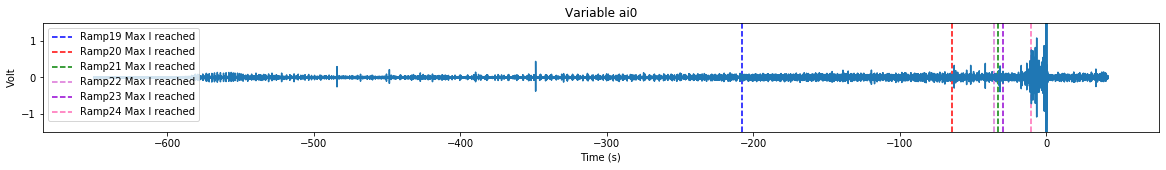

Flushing input history
Flushing input history


In [10]:
load_and_plot("./data/Ramp25/", "ai0", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


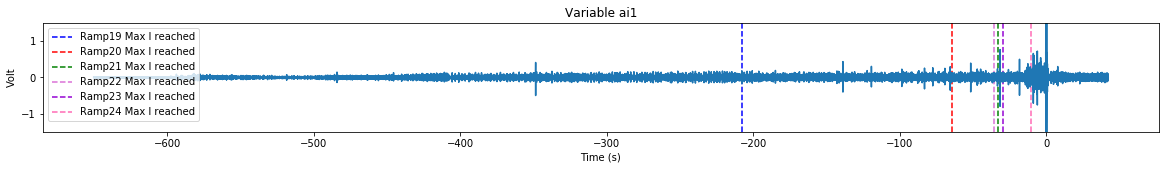

Flushing input history
Flushing input history


In [11]:
load_and_plot("./data/Ramp25/", "ai1", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


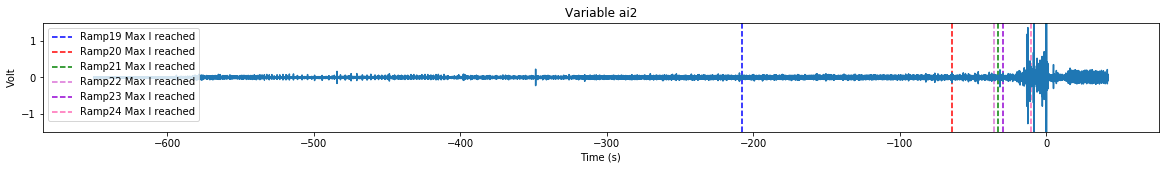

Flushing input history
Flushing input history


In [12]:
load_and_plot("./data/Ramp25/", "ai2", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


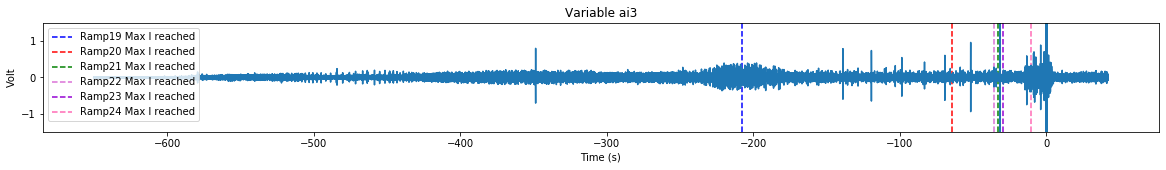

Flushing input history
Flushing input history


In [13]:
load_and_plot("./data/Ramp25/", "ai3", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


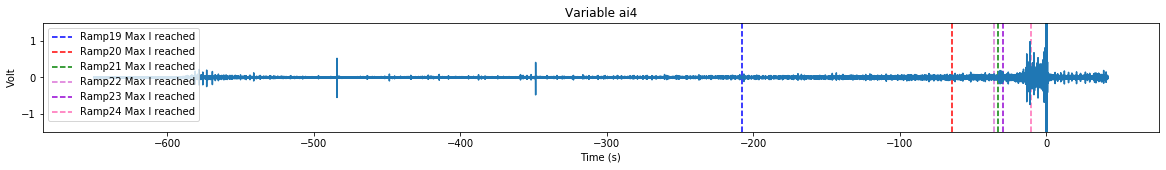

Flushing input history
Flushing input history


In [14]:
load_and_plot("./data/Ramp25/", "ai4", max_current = True)

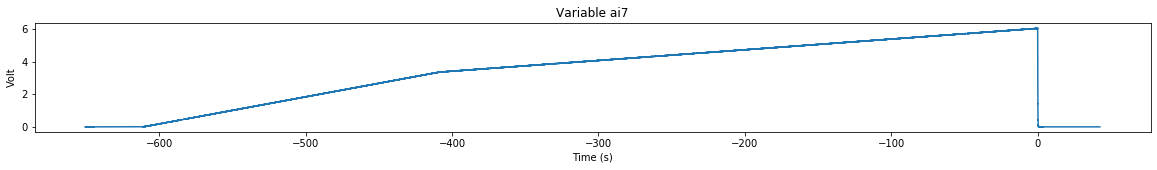

Flushing input history
Flushing input history


In [15]:
load_and_plot("./data/Ramp25/", "ai7")

In [6]:
data = load_channel_and_time("./data/Ramp25/", "ai7")

print(data[data['time'] == 0])

               ai7  time
65041462  6.056884   0.0


## Ramp 26 -- MQXFS1D -- 29.May.2018 18:04

### 26.1 Main quench data 

In [4]:
quench26 = all_quench['mqxfs1d.Quench.180529180450']

V1_VoAqdHcoilHcoilM_1


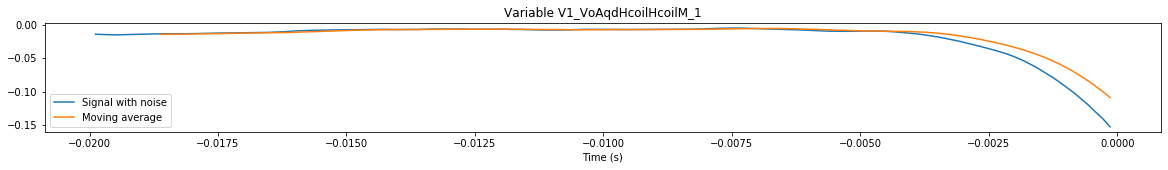

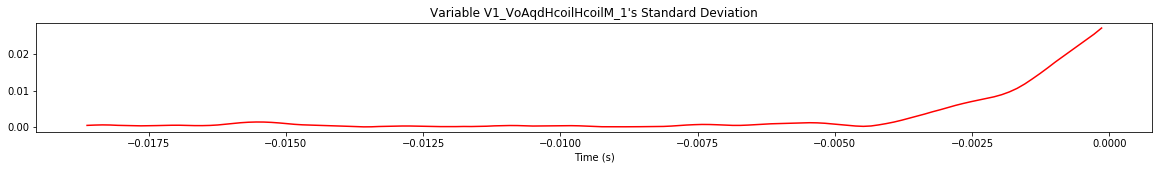

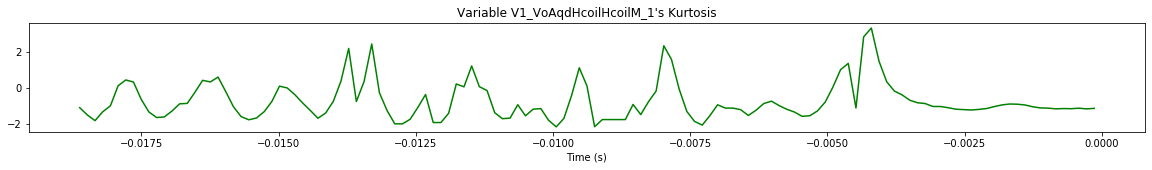

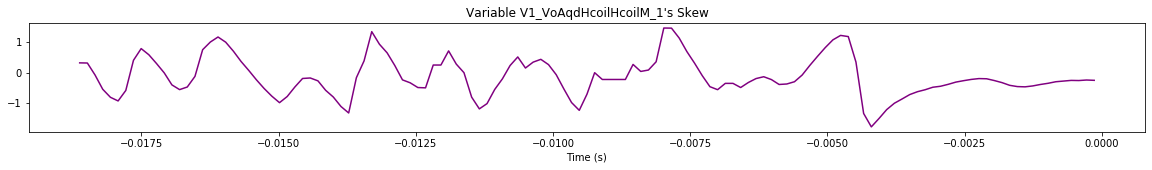

Flushing input history


In [6]:
plot_statistics(quench26, variables = ['V1_VoAqdHcoilHcoilM_1'], time_range = (-20e-3,0), window = 10)

### 26.2 Acoustic data

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


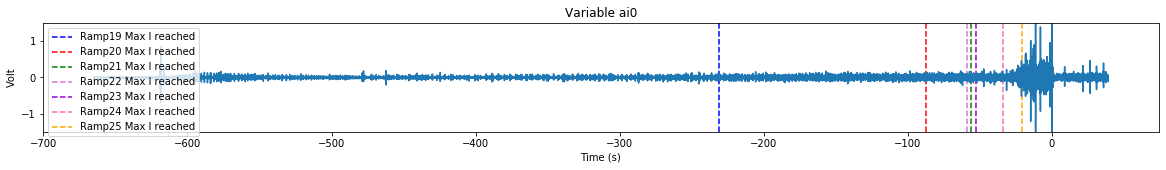

Flushing input history
Flushing input history


In [12]:
load_and_plot("./data/Ramp26/", "ai0", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


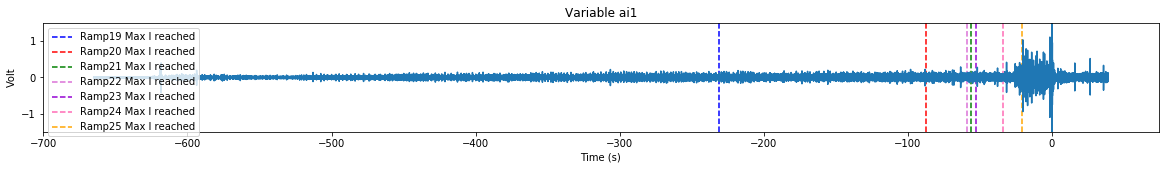

Flushing input history
Flushing input history


In [13]:
load_and_plot("./data/Ramp26/", "ai1", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


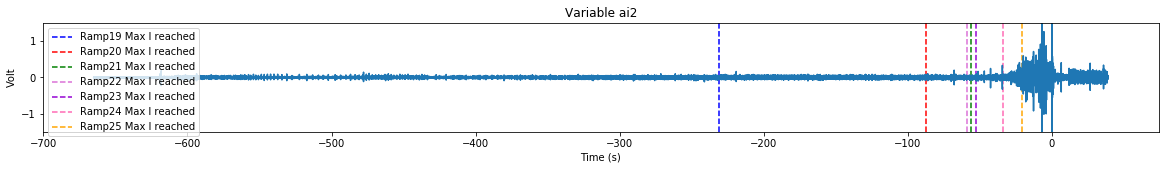

Flushing input history
Flushing input history


In [14]:
load_and_plot("./data/Ramp26/", "ai2", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


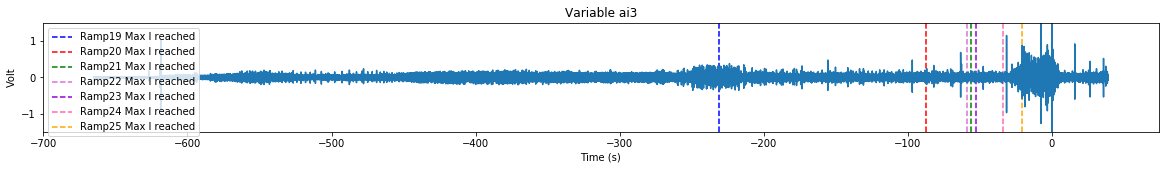

Flushing input history
Flushing input history


In [15]:
load_and_plot("./data/Ramp26/", "ai3", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


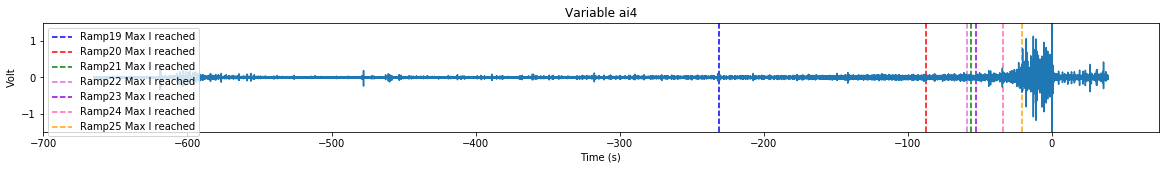

Flushing input history
Flushing input history


In [16]:
load_and_plot("./data/Ramp26/", "ai4", max_current = True)

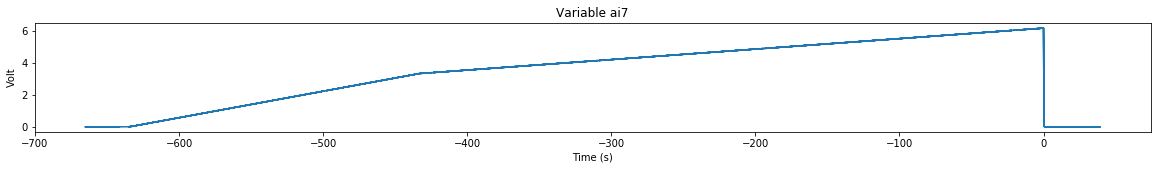

Flushing input history
Flushing input history


In [18]:
load_and_plot("./data/Ramp26/", "ai7")

In [9]:
data = load_channel_and_time("./data/Ramp26/", "ai7")

print(data[data['time'] == 0])

              ai7  time
66507423  6.19826   0.0


## Ramp 27 -- MQXFS1D -- 31.May.2018 11:45

### 27.1 Main quench data

In [24]:
#quench27 = all_quench['mqxfs1d.Quench.180531114534']

In [23]:
#plot_statistics(quench27, time_range = (-20e-3,0), window = 10)

### 27.2 Acoustic data

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


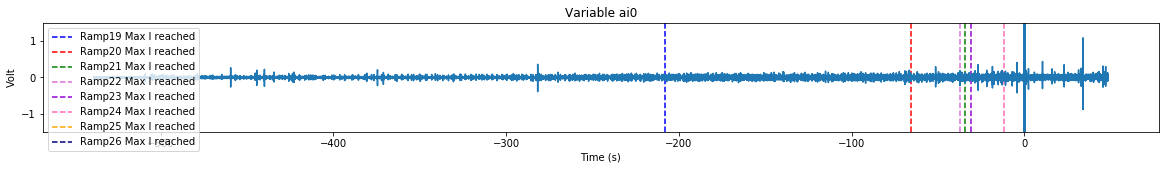

Flushing input history
Flushing input history


In [35]:
load_and_plot("./data/Ramp27/", "ai0", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


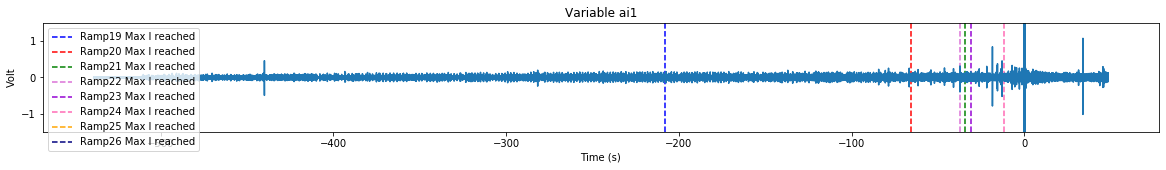

Flushing input history
Flushing input history


In [36]:
load_and_plot("./data/Ramp27/", "ai1", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


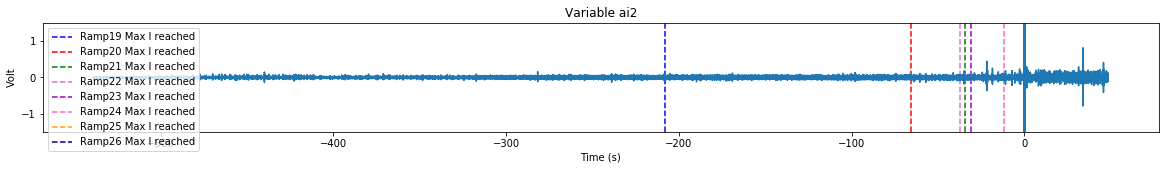

Flushing input history
Flushing input history


In [37]:
load_and_plot("./data/Ramp27/", "ai2", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


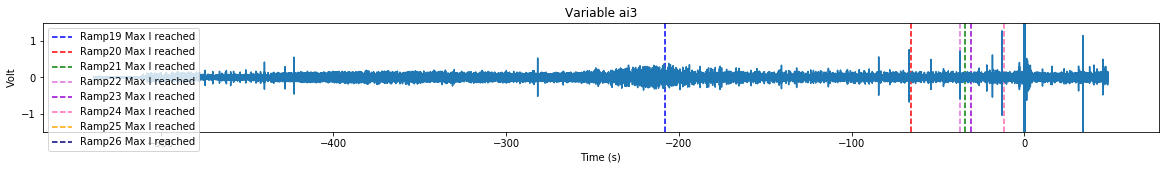

Flushing input history
Flushing input history


In [46]:
load_and_plot("./data/Ramp27/", "ai3", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


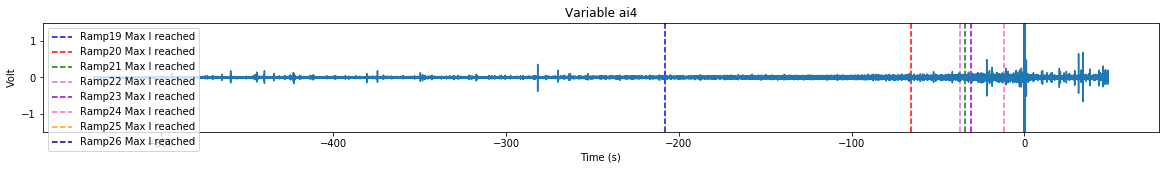

Flushing input history
Flushing input history


In [39]:
load_and_plot("./data/Ramp27/", "ai4", max_current = True)

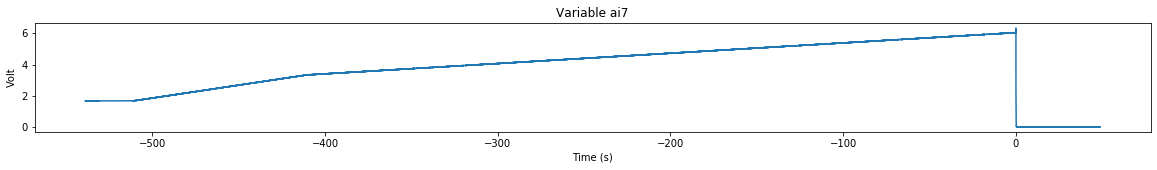

Flushing input history
Flushing input history


In [44]:
load_and_plot("./data/Ramp27/", "ai7")

In [28]:
data = load_channel_and_time("./data/Ramp27/", "ai7")

print(data[data['time'] == 0])

               ai7  time
53875393  6.342255   0.0


In [45]:
calculate_max_current_time("./data/Ramp27/", 24)

Flushing input history


-11.831699

## Ramp 28 -- MQXFS1D -- 31.May.2018 18:24

### 28.1 Main quench data

In [50]:
#quench28 = all_quench['mqxfs1d.Quench.180531182410']

In [51]:
#plot_statistics(quench28, time_range = (-20e-3,0), window = 10)

### 28.2 Acoustic data

ai0


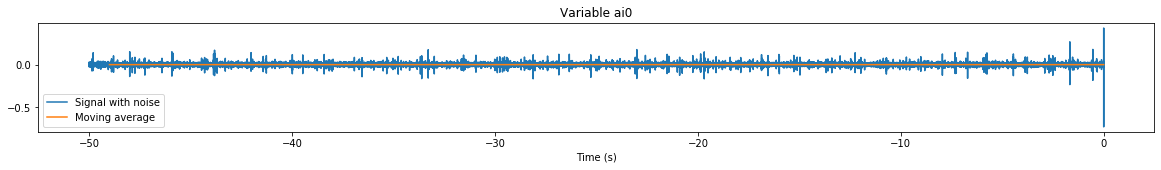

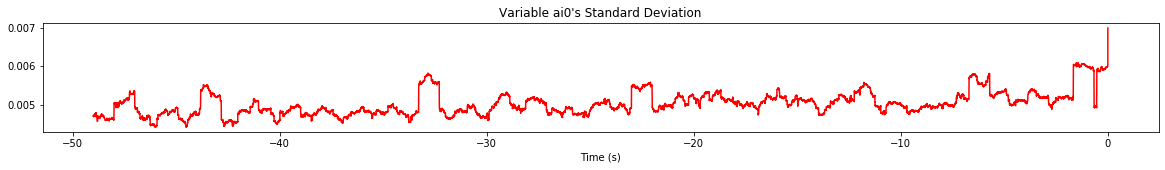

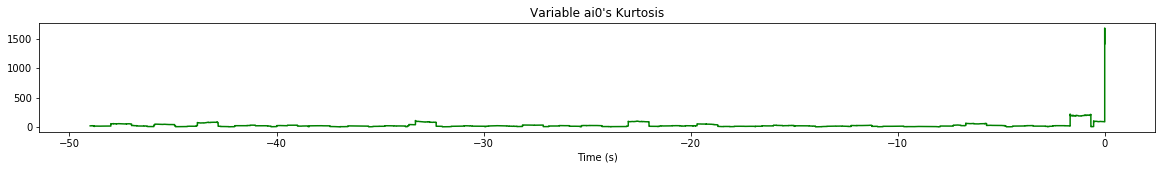

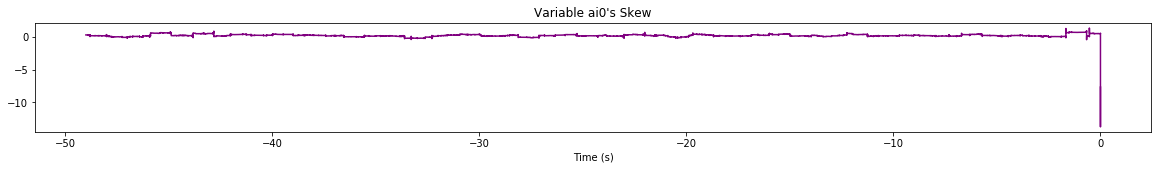

Flushing input history
Flushing input history


In [10]:
load_and_plot("./data/Ramp28/", "ai0", time_range = (-50,0), stat = True, window = 100000)

ai1


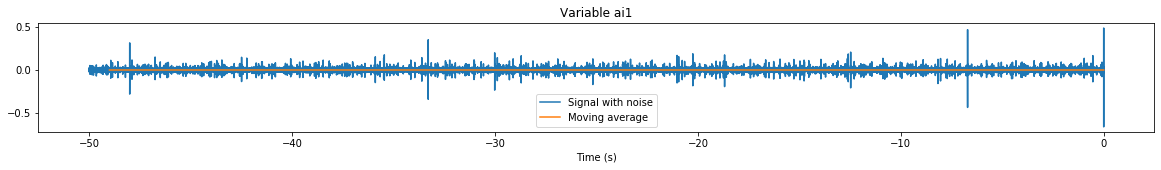

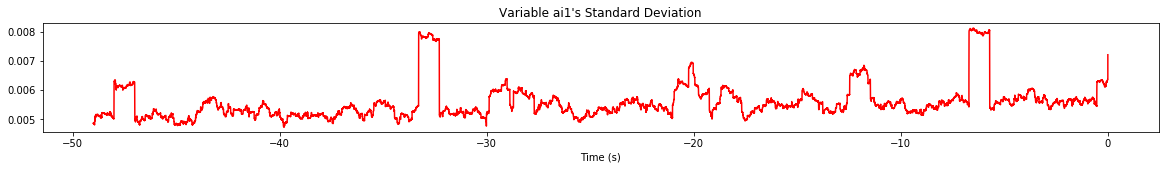

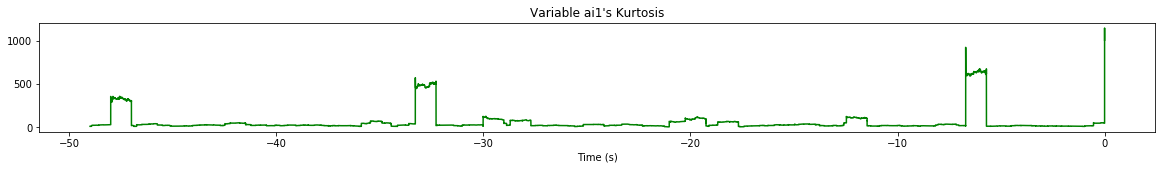

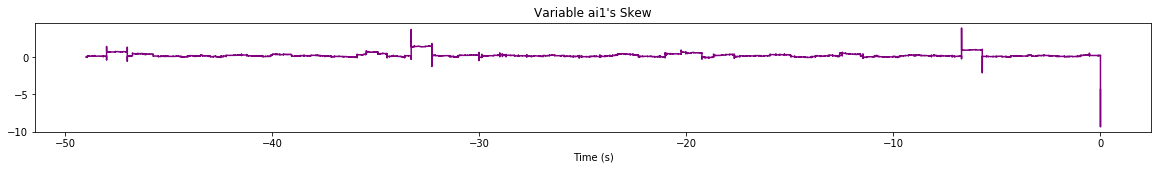

Flushing input history
Flushing input history


In [11]:
load_and_plot("./data/Ramp28/", "ai1", time_range = (-50,0), stat = True, window = 100000)

ai2


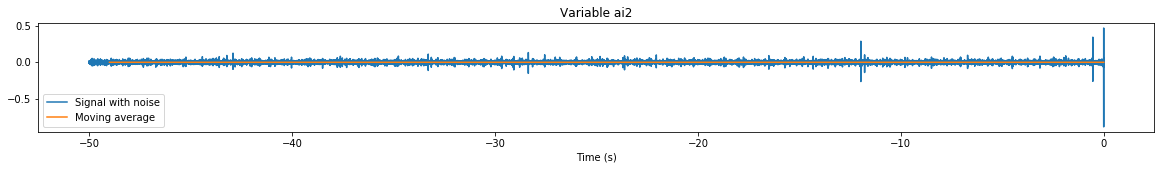

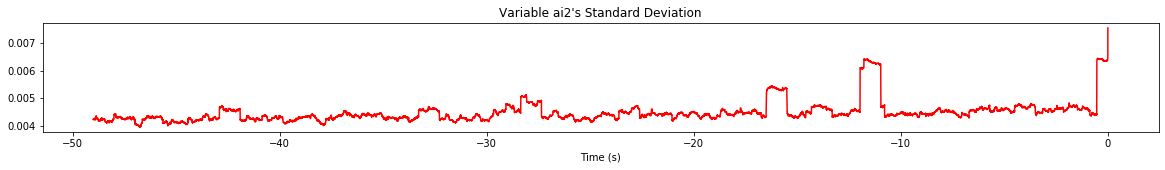

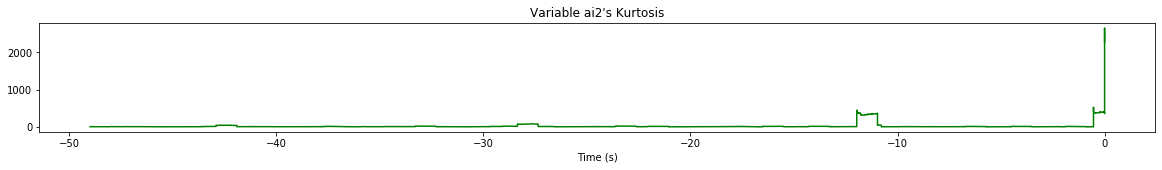

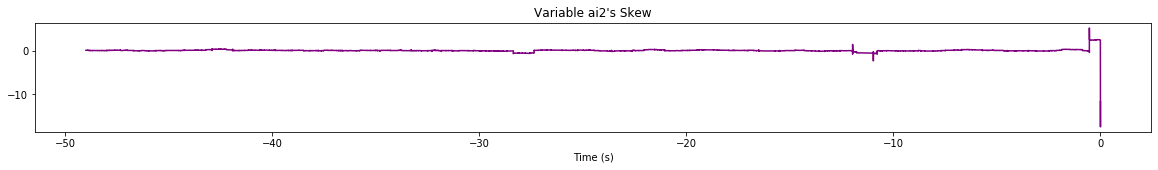

Flushing input history
Flushing input history


In [12]:
load_and_plot("./data/Ramp28/", "ai2", time_range = (-50,0), stat = True, window = 100000)

ai3


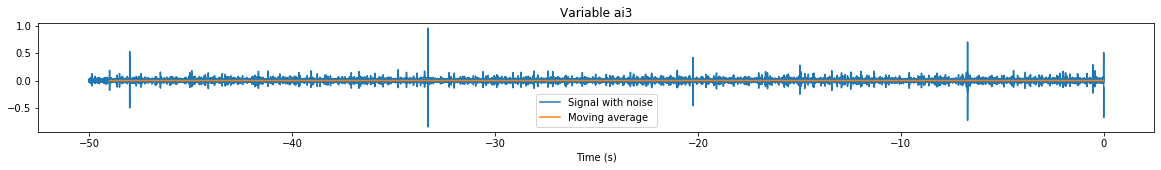

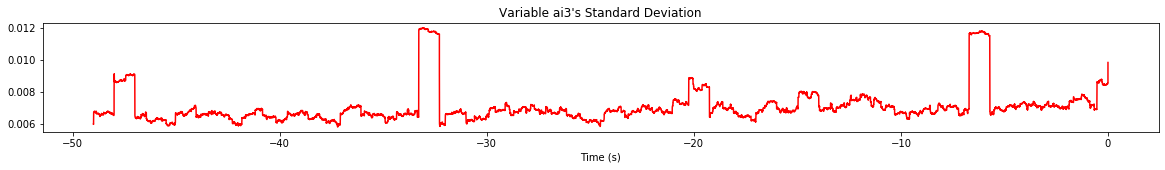

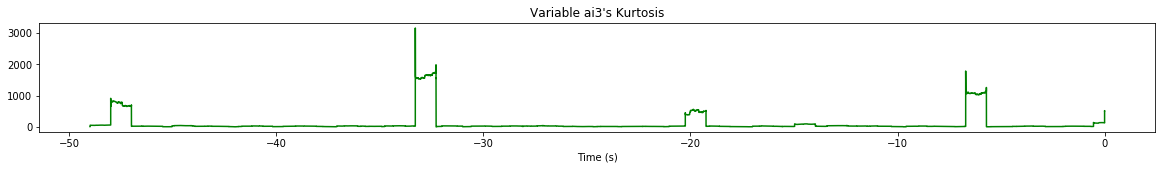

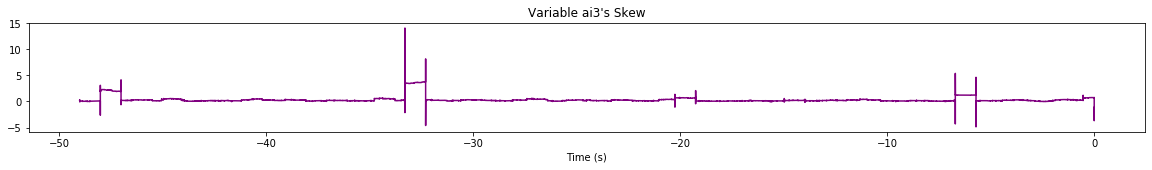

Flushing input history
Flushing input history


In [13]:
load_and_plot("./data/Ramp28/", "ai3", time_range = (-50,0), stat = True, window = 100000)

ai4


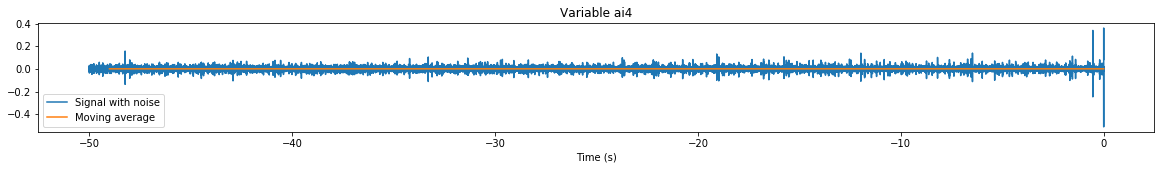

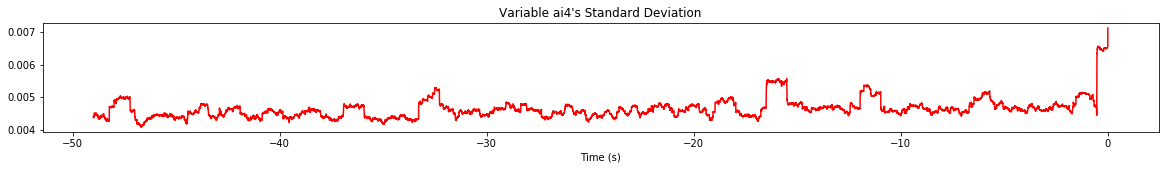

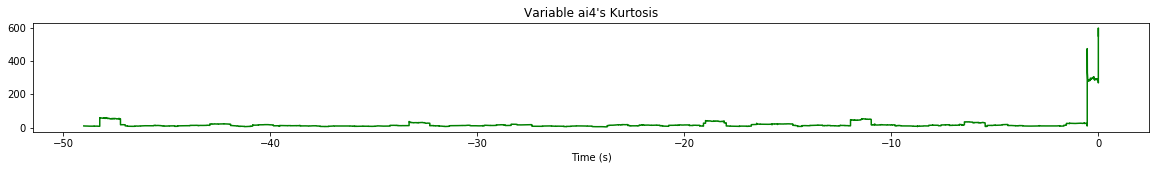

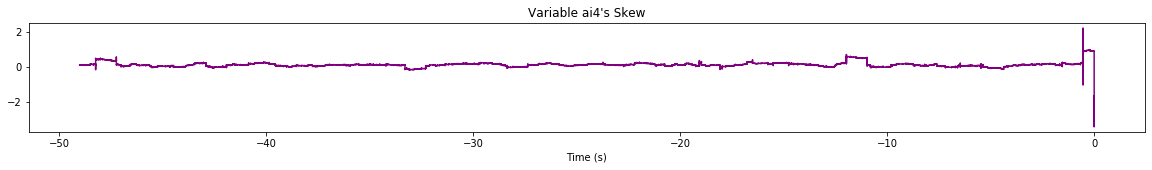

Flushing input history
Flushing input history


In [14]:
load_and_plot("./data/Ramp28/", "ai4", time_range = (-50,0), stat = True, window = 100000)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


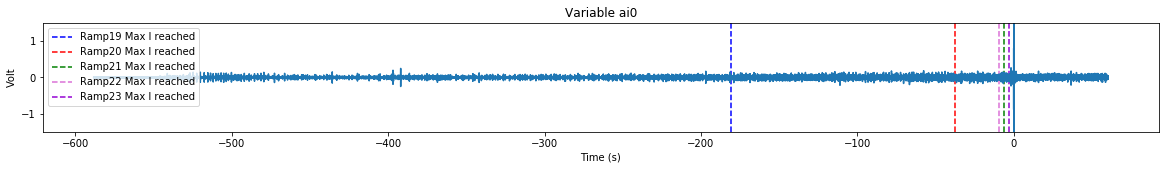

Flushing input history
Flushing input history


In [8]:
load_and_plot("./data/Ramp28/", "ai0", max_current = True)

ai1


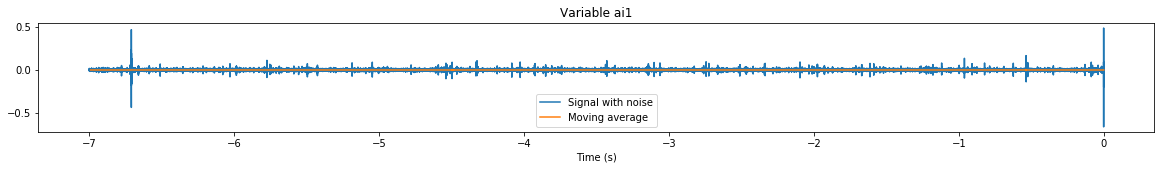

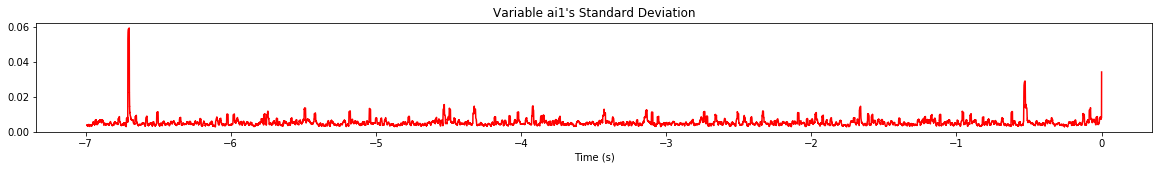

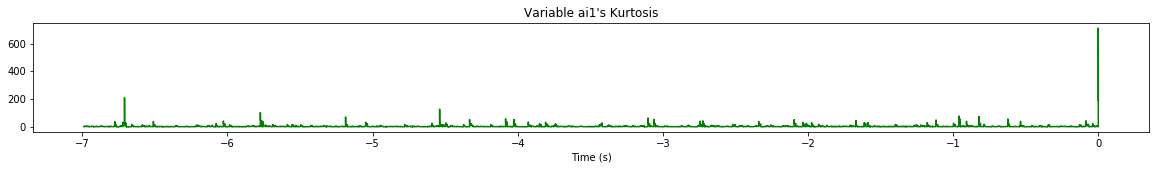

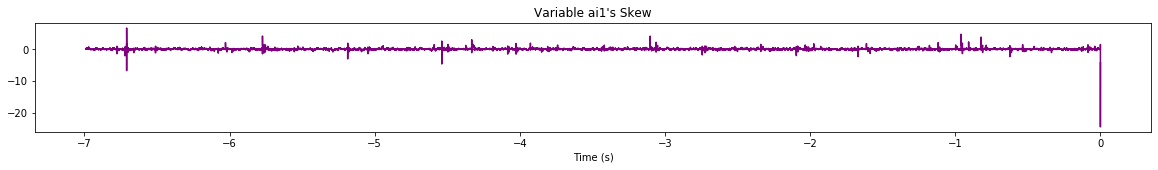

Flushing input history
Flushing input history


In [29]:
load_and_plot("./data/Ramp28/", "ai1", time_range = (-7, 0), stat = True, window = 1000)

ai1


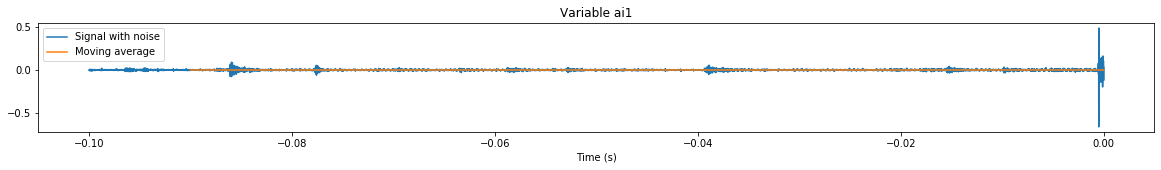

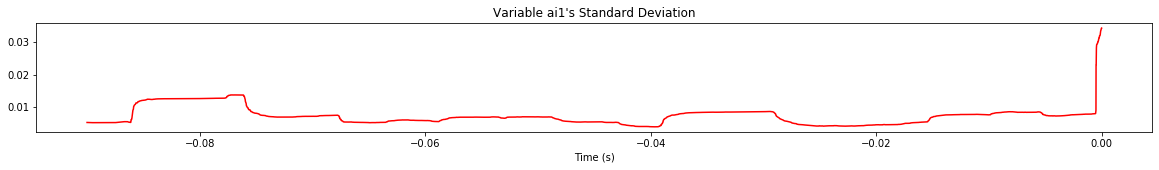

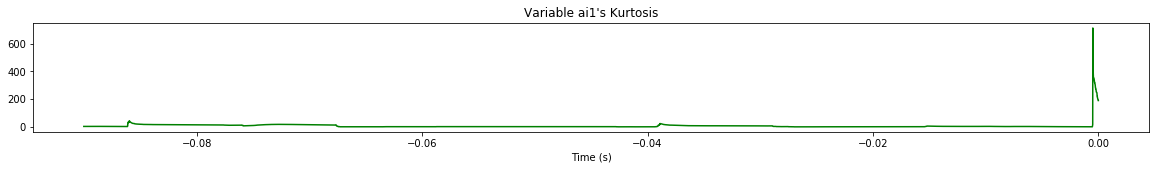

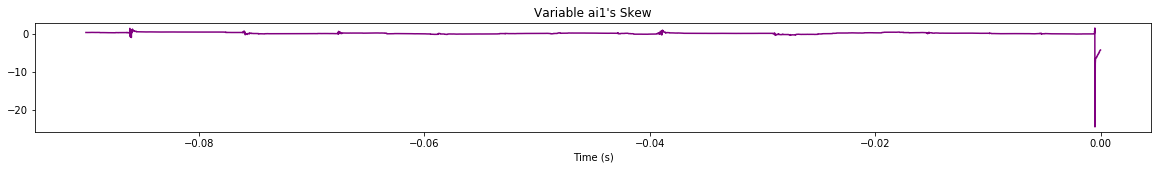

Flushing input history
Flushing input history


In [21]:
load_and_plot("./data/Ramp28/", "ai1", time_range = (-100e-3, 0), stat = True, window = 1000)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


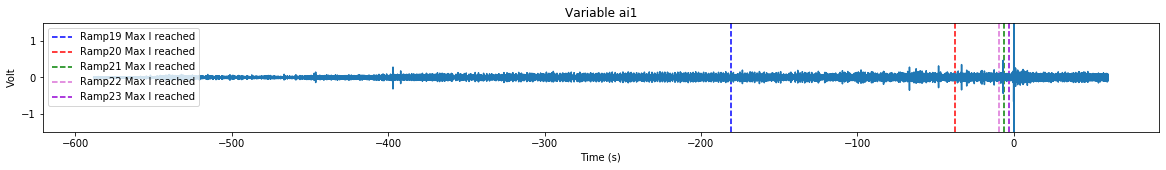

Flushing input history
Flushing input history


In [9]:
load_and_plot("./data/Ramp28/", "ai1", max_current = True)

ai2


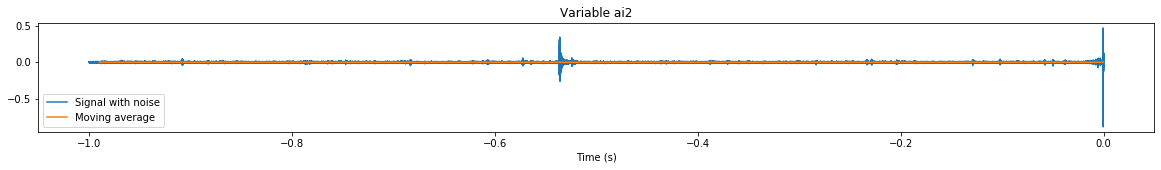

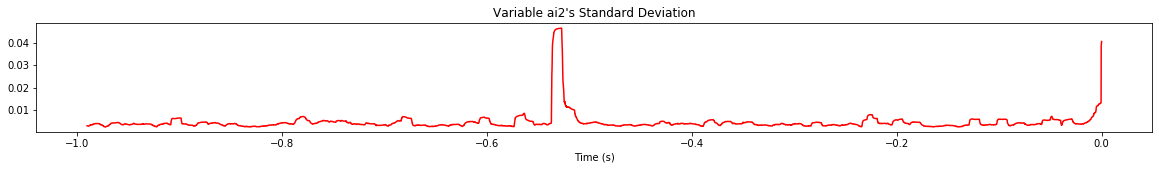

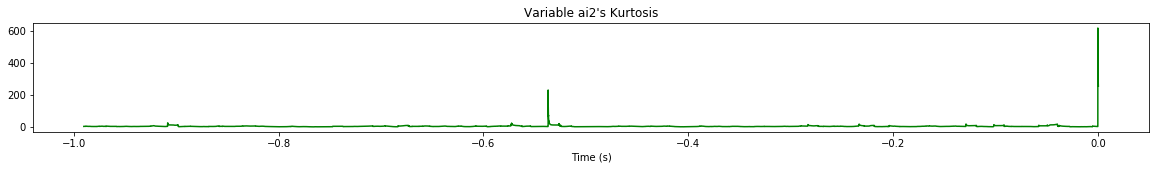

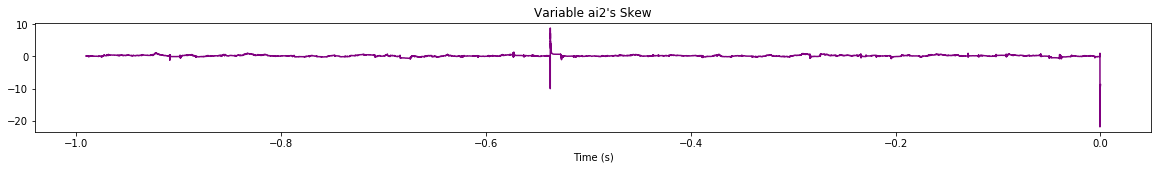

Flushing input history
Flushing input history


In [25]:
load_and_plot("./data/Ramp28/", "ai2", time_range = (-1, 0), stat = True, window = 1000)

ai2


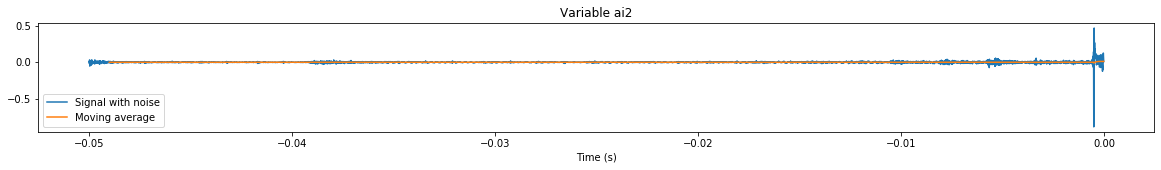

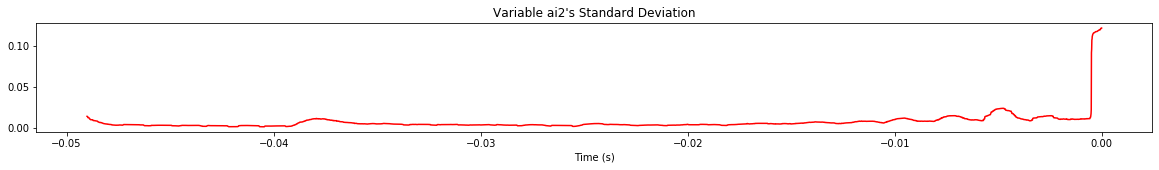

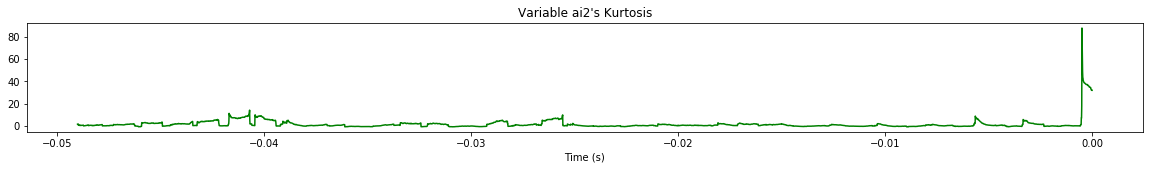

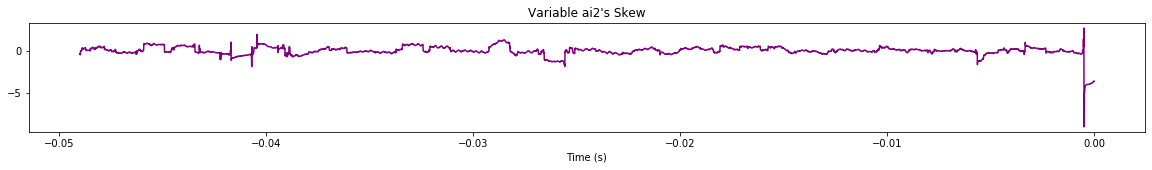

Flushing input history
Flushing input history


In [27]:
load_and_plot("./data/Ramp28/", "ai2", time_range = (-50e-3, 0), stat = True, window = 100)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


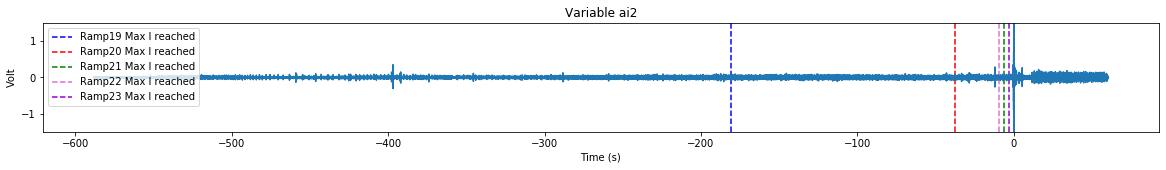

Flushing input history
Flushing input history


In [10]:
load_and_plot("./data/Ramp28/", "ai2", max_current = True)

In [ ]:
load_and_plot("./data/Ramp28/", "ai2", time_range = (-50, 0), stat = True, window = 200000)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


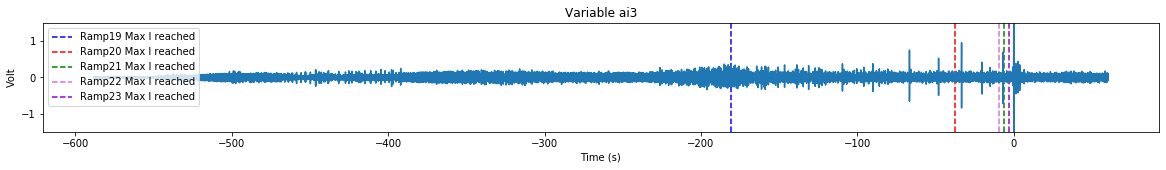

Flushing input history
Flushing input history


In [11]:
load_and_plot("./data/Ramp28/", "ai3", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


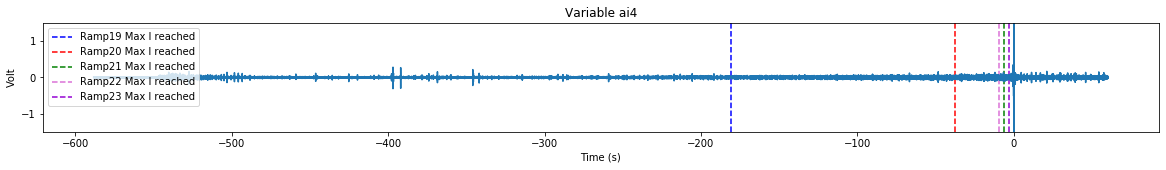

Flushing input history
Flushing input history


In [12]:
load_and_plot("./data/Ramp28/", "ai4", max_current = True)

In [6]:
data = load_channel_and_time("./data/Ramp28/", "ai7")

print(data[data['time'] == 0])

               ai7  time
58831430  5.870774   0.0


In [13]:
calculate_max_current_time("./data/Ramp28/", 23)

Flushing input history


-3.2126899

In [19]:
calculate_max_current_time("./data/Ramp28/", 20)

Flushing input history


-37.69087

In [20]:
calculate_max_current_time("./data/Ramp28/", 21)

Flushing input history


-6.3182297

In [21]:
calculate_max_current_time("./data/Ramp28/", 22)

Flushing input history


-9.10448

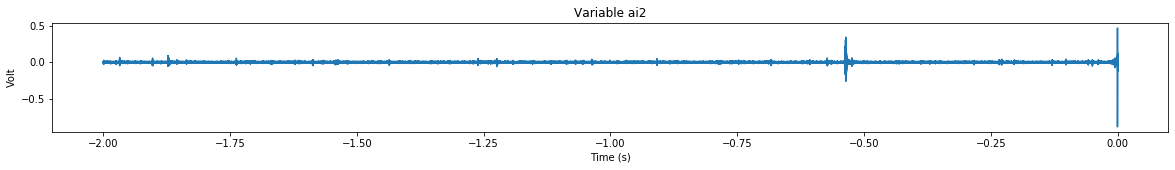

Flushing input history
Flushing input history


In [40]:
load_and_plot("./data/Ramp28/", "ai2", time_range = (-2, 0))

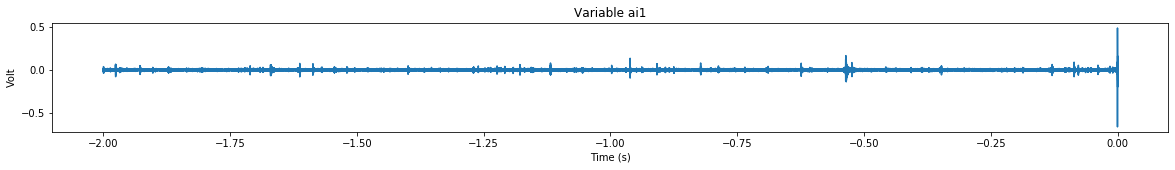

Flushing input history
Flushing input history


In [41]:
load_and_plot("./data/Ramp28/", "ai1", time_range = (-2, 0))

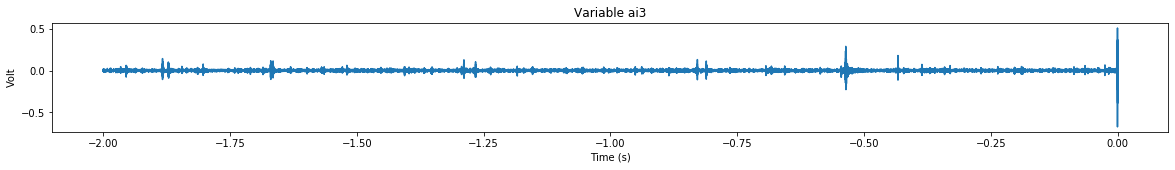

Flushing input history
Flushing input history


In [42]:
load_and_plot("./data/Ramp28/", "ai3", time_range = (-2, 0))

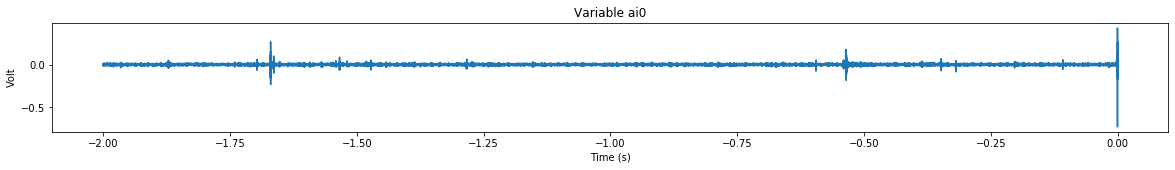

Flushing input history
Flushing input history


In [43]:
load_and_plot("./data/Ramp28/", "ai0", time_range = (-2, 0))

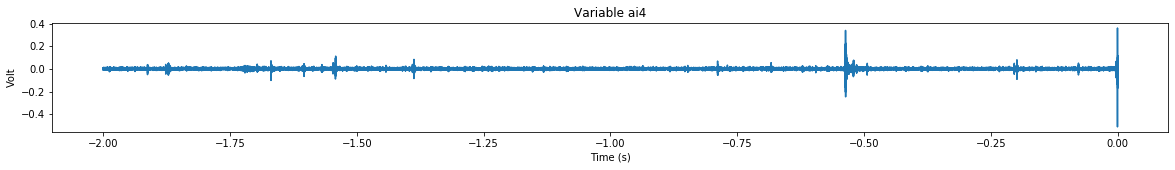

Flushing input history
Flushing input history


In [44]:
load_and_plot("./data/Ramp28/", "ai4", time_range = (-2, 0))

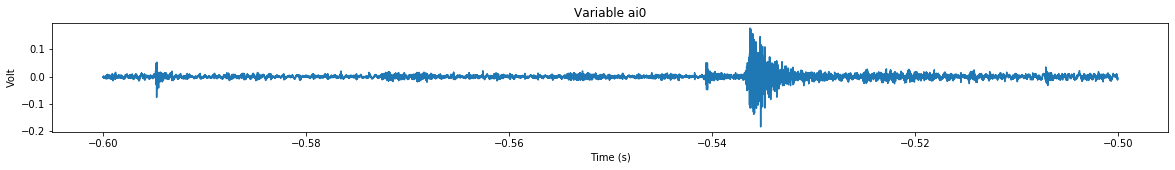

Flushing input history
Flushing input history


In [3]:
load_and_plot("./data/Ramp28/", "ai0", time_range = (-600e-3, -500e-3))

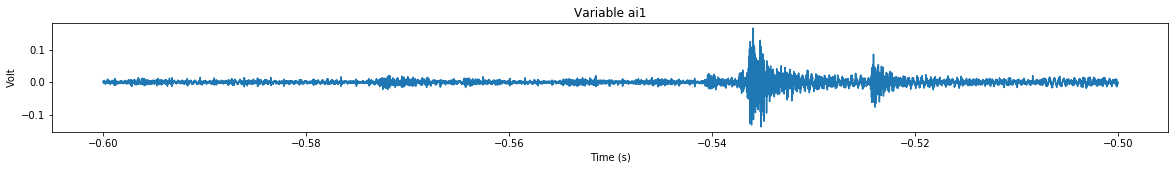

Flushing input history
Flushing input history


In [4]:
load_and_plot("./data/Ramp28/", "ai1", time_range = (-600e-3, -500e-3))

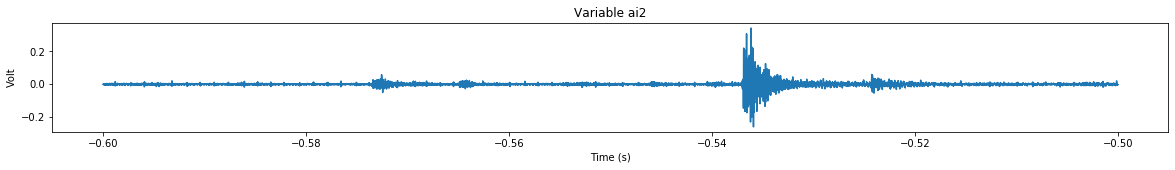

Flushing input history
Flushing input history


In [5]:
load_and_plot("./data/Ramp28/", "ai2", time_range = (-600e-3, -500e-3))

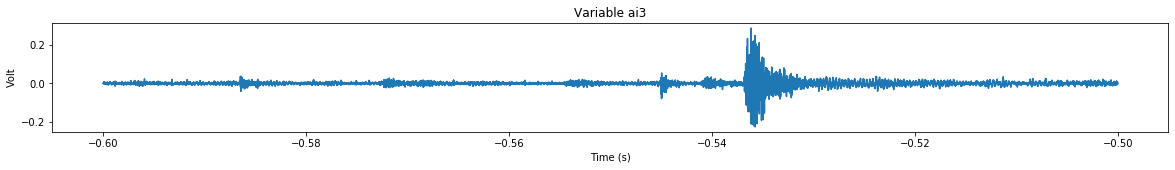

Flushing input history
Flushing input history


In [6]:
load_and_plot("./data/Ramp28/", "ai3", time_range = (-600e-3, -500e-3))

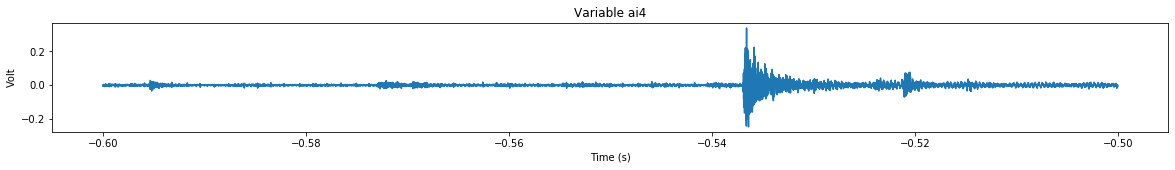

Flushing input history
Flushing input history


In [7]:
load_and_plot("./data/Ramp28/", "ai4", time_range = (-600e-3, -500e-3))

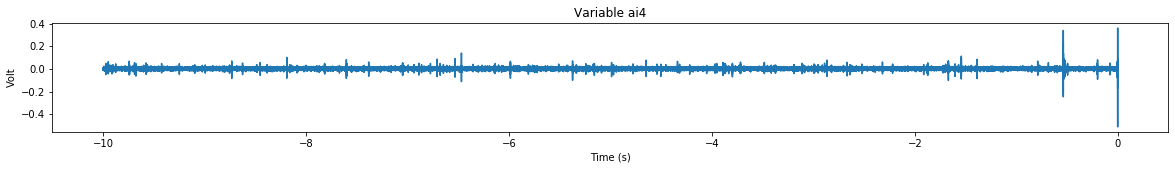

Flushing input history
Flushing input history


In [50]:
load_and_plot("./data/Ramp28/", "ai4", time_range = (-10, 0))

## Ramp 29 -- MQXFS1D -- 04.Jun.2018 12:14

### 29.1 Main quench data

In [38]:
#quench29 = all_quench['mqxfs1d.Quench.180604121444']

In [39]:
#plot_statistics(quench29, variables = ['V1_VoAqdHcoilHcoilM_1'], time_range = (-20e-3,0), window = 10)

### 29.2 Acoustic data

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


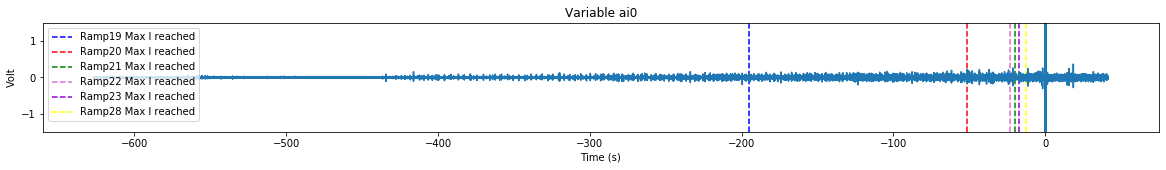

Flushing input history
Flushing input history


In [6]:
load_and_plot("./data/Ramp29/", "ai0", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


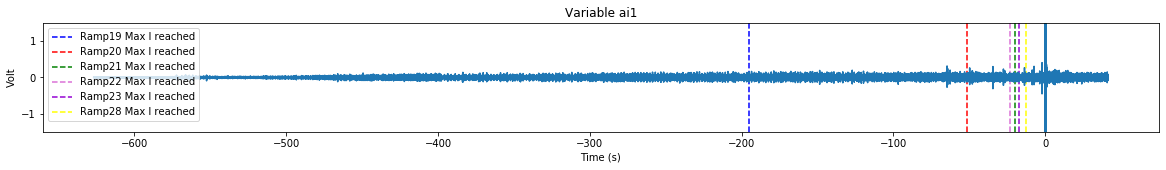

Flushing input history
Flushing input history


In [7]:
load_and_plot("./data/Ramp29/", "ai1", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


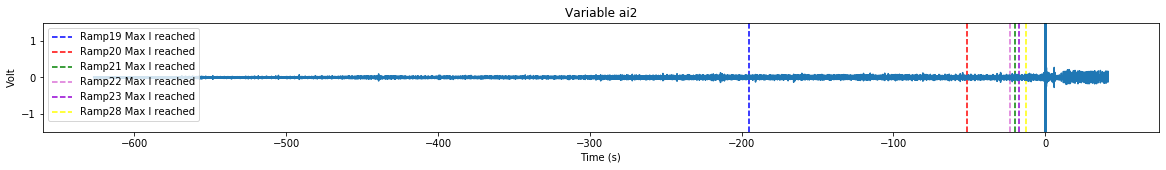

Flushing input history
Flushing input history


In [8]:
load_and_plot("./data/Ramp29/", "ai2", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


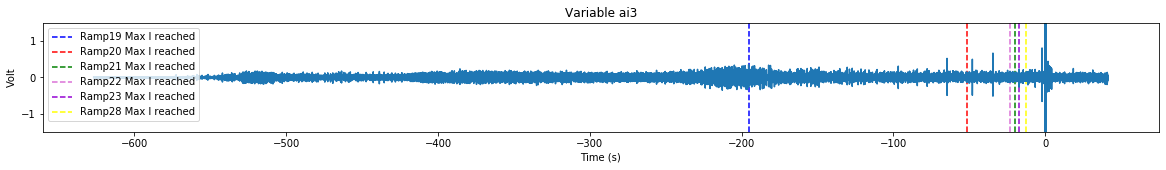

Flushing input history
Flushing input history


In [9]:
load_and_plot("./data/Ramp29/", "ai3", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


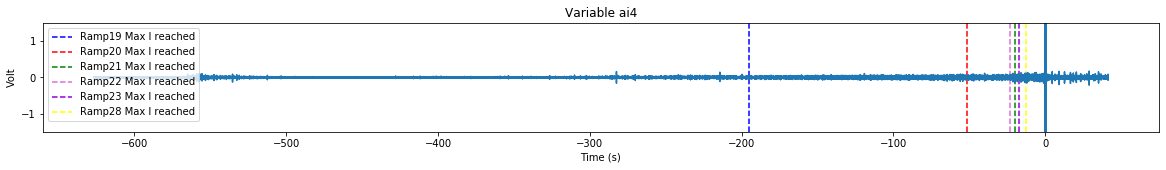

Flushing input history
Flushing input history


In [10]:
load_and_plot("./data/Ramp29/", "ai4", max_current = True)

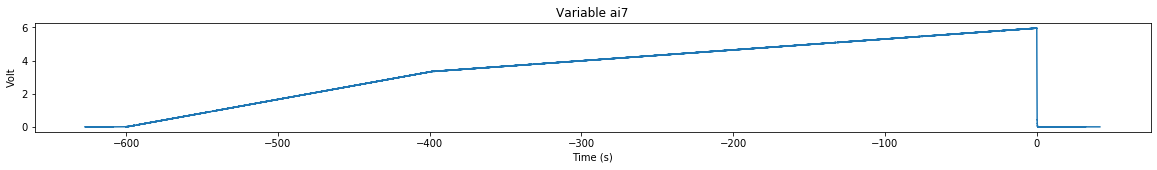

Flushing input history
Flushing input history


In [15]:
load_and_plot("./data/Ramp29/", "ai7")

In [49]:
data = load_channel_and_time("./data/Ramp29/", "ai7")

print(data[data['time'] == 0])

               ai7  time
62686638  5.961583   0.0


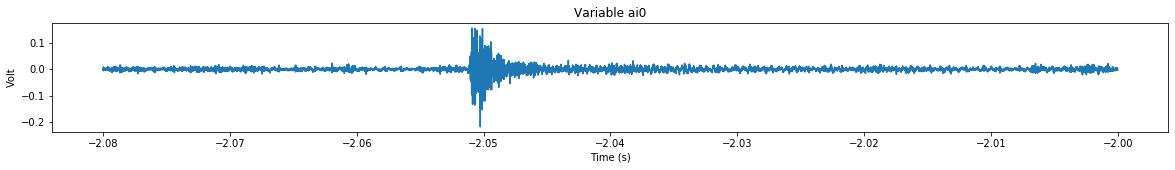

Flushing input history
Flushing input history


In [33]:
load_and_plot("./data/Ramp29/", "ai0", time_range = (-2.08, -2))

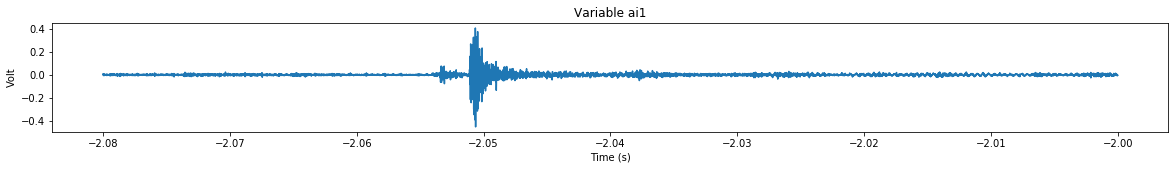

Flushing input history
Flushing input history


In [34]:
load_and_plot("./data/Ramp29/", "ai1", time_range = (-2.08, -2))

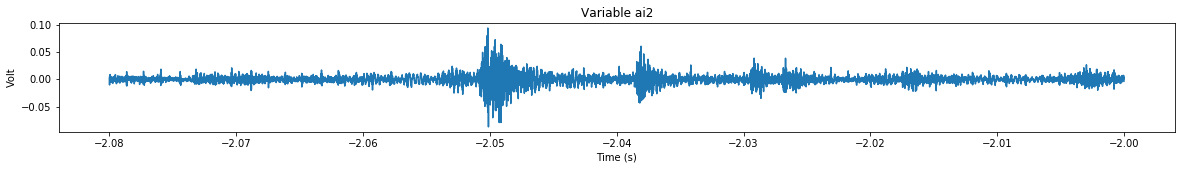

Flushing input history
Flushing input history


In [35]:
load_and_plot("./data/Ramp29/", "ai2", time_range = (-2.08, -2))

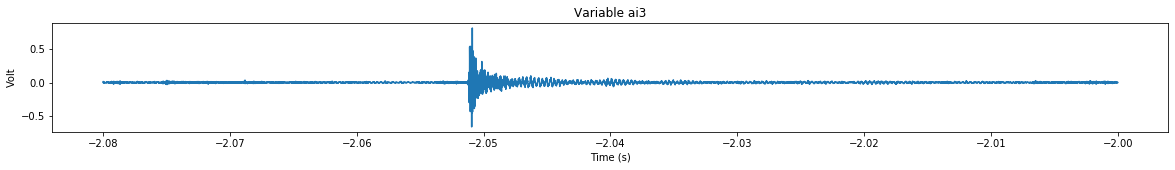

Flushing input history
Flushing input history


In [36]:
load_and_plot("./data/Ramp29/", "ai3", time_range = (-2.08, -2))

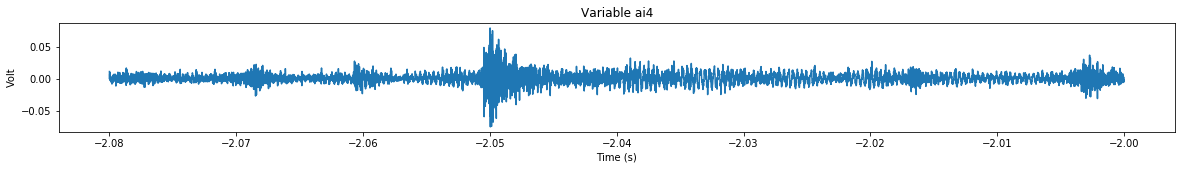

Flushing input history
Flushing input history


In [37]:
load_and_plot("./data/Ramp29/", "ai4", time_range = (-2.08, -2))

## Ramp 30 -- MQXFS1D -- 04.Jun.2018 15:28

### 30.1 Main quench data

In [17]:
#quench30 = all_quench['mqxfs1d.Quench.180604152848']

In [15]:
#plot_statistics(quench30, time_range = (-20e-3,0), window = 10)

### 30.2 Acoustic data

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


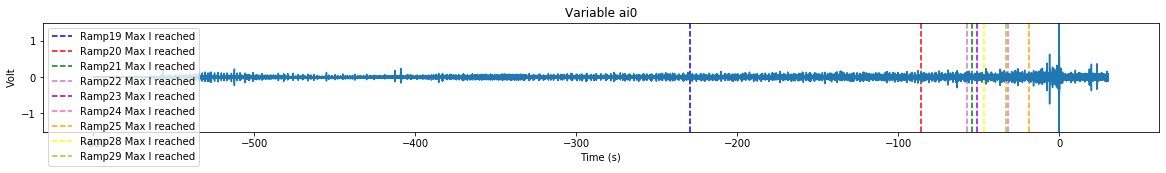

Flushing input history
Flushing input history


In [21]:
load_and_plot("./data/Ramp30/", "ai0", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


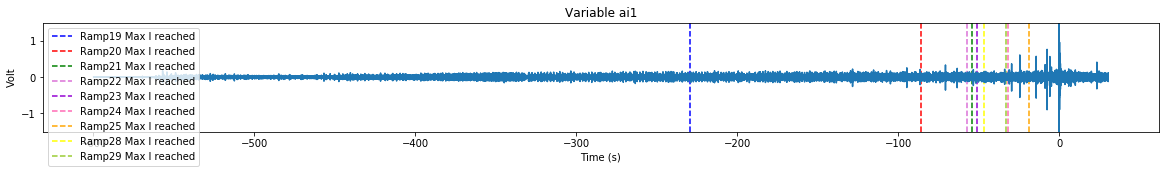

Flushing input history
Flushing input history


In [27]:
load_and_plot("./data/Ramp30/", "ai1", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


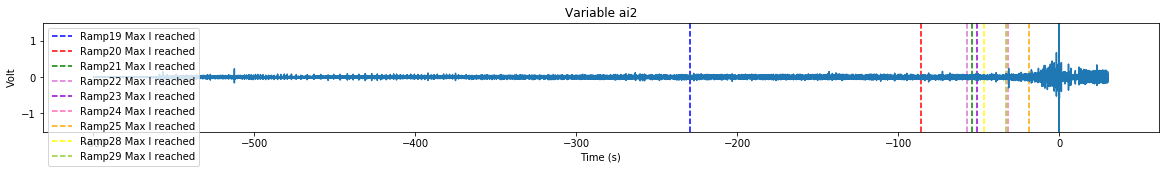

Flushing input history
Flushing input history


In [28]:
load_and_plot("./data/Ramp30/", "ai2", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


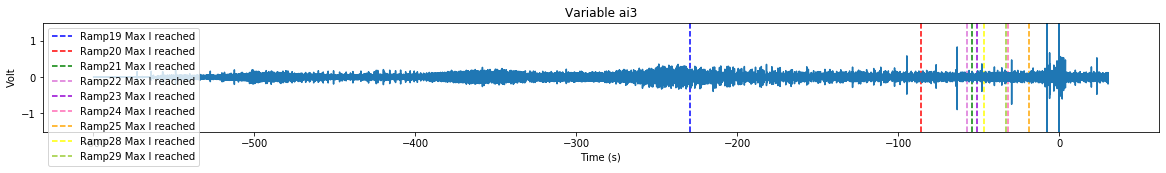

Flushing input history
Flushing input history


In [29]:
load_and_plot("./data/Ramp30/", "ai3", max_current = True)

Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history
Flushing input history


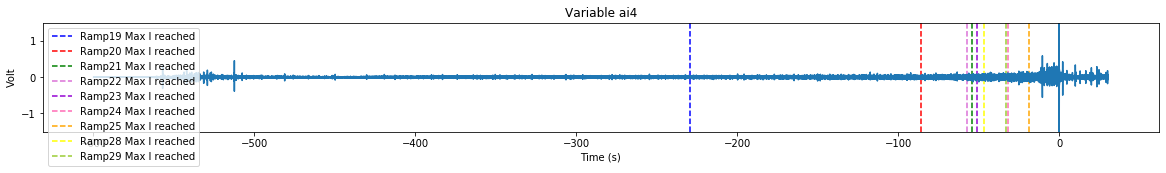

Flushing input history
Flushing input history


In [30]:
load_and_plot("./data/Ramp30/", "ai4", max_current = True)

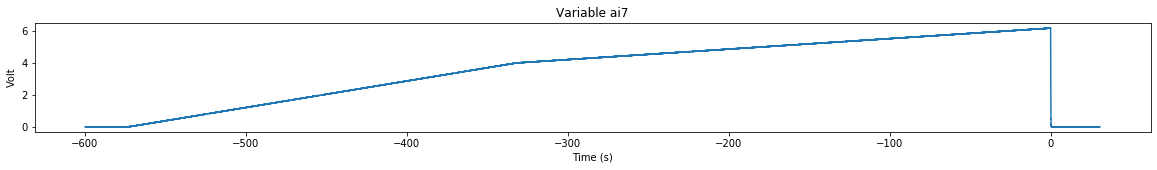

Flushing input history
Flushing input history


In [31]:
load_and_plot("./data/Ramp30/", "ai7")

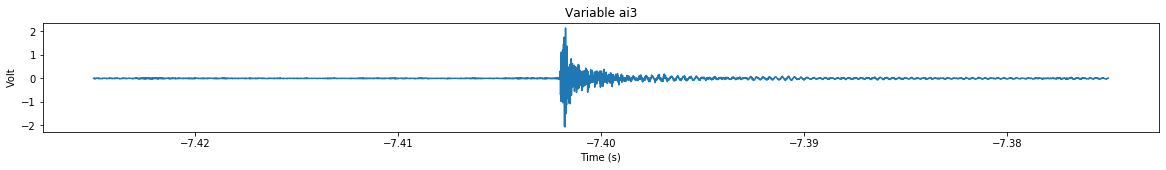

Flushing input history
Flushing input history


In [45]:
load_and_plot("./data/Ramp30/", "ai3", time_range = (-7.425, -7.375))

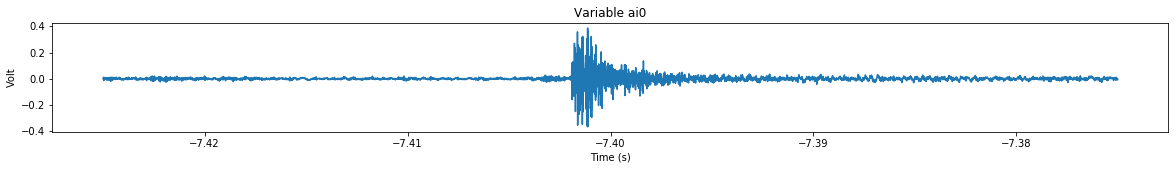

Flushing input history
Flushing input history


In [46]:
load_and_plot("./data/Ramp30/", "ai0", time_range = (-7.425, -7.375))

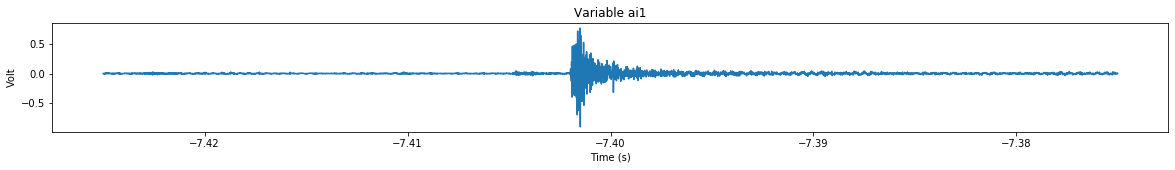

Flushing input history
Flushing input history


In [47]:
load_and_plot("./data/Ramp30/", "ai1", time_range = (-7.425, -7.375))

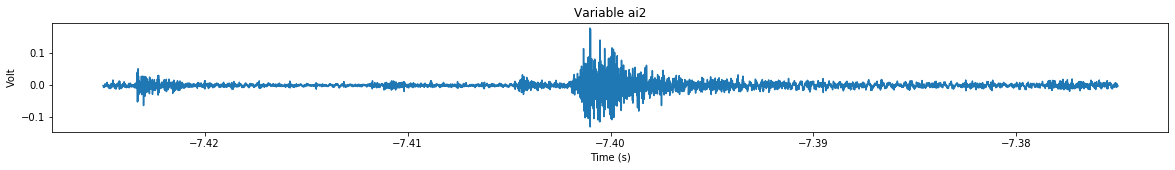

Flushing input history
Flushing input history


In [48]:
load_and_plot("./data/Ramp30/", "ai2", time_range = (-7.425, -7.375))

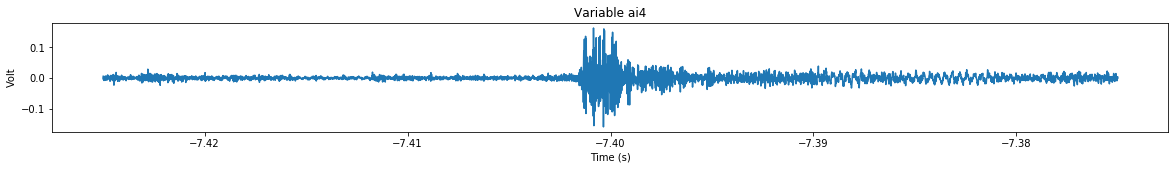

Flushing input history
Flushing input history


In [49]:
load_and_plot("./data/Ramp30/", "ai4", time_range = (-7.425, -7.375))